### Imports

In [7]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import csv

from astropy.io import fits
from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
#from astropy.units import cds
#cds.enable()

from astropy.cosmology import LambdaCDM, FlatLambdaCDM

from PIL import Image

from astropy.io import ascii
from astropy.io.ascii import masked
from astropy.table import Table

from scipy.interpolate import interp1d
from numpy import polyfit
from astropy.time import Time

import uncertainties as unc  
import uncertainties.unumpy as unp

In [8]:
manga_file = fits.open(r"C:\Users\paiaa\Downloads\mnsa-0.3.0.fits")
spitzer_file = fits.open(r"C:\Users\paiaa\Downloads\asu (2).fit")
pipe3d_file = fits.open(r"C:\Users\paiaa\Downloads\SDSS17Pipe3D_v3_1_1.fits")

In [9]:
hdu_manga = manga_file[2]
hdu_p3d = pipe3d_file[1]
hdu_spitzer = spitzer_file[1]

manga_data = hdu_manga.data
p3d_data = hdu_p3d.data
spitzer_data = hdu_spitzer.data

galaxy_data = pd.read_csv('galaxy_data.csv')
#galaxy_data

### Writing IPAC Table to Query WISE

In [10]:
#finding indices of selected objects
index = np.array([])  
for i in range(galaxy_data['plateifu'].shape[0]):
    for j in range(manga_data.shape[0]):
        if manga_data['plateifu'][j] == galaxy_data['plateifu'][i]:
            index = np.append(index, j)

In [11]:
#finding RA and DEC of selected objects
#RA = manga_file[1].data['objra'][index.astype(int)]
#dec = manga_file[1].data['objdec'][index.astype(int)]

RA = manga_file[1].data['objra']
dec = manga_file[1].data['objdec']

In [12]:
#creating Table object with ra and dec columns
table = Table([RA, dec], names=('ra', 'dec'))
#table.write('objects_all.tbl', format = 'ipac', overwrite = True)

table[0:]

ra,dec
float64,float64
133.371090612,57.5984251446
133.685669869,57.4802503218
136.017159969,57.0923291779
133.989966869,57.6779676669
136.75137451,57.4514369241
133.330028009,57.0411553708
134.193923352,56.7867469988
132.465646765,57.1437279024
132.912768243,57.1074235568


### Importing results of query as CSV

In [13]:
neowise_data = pd.read_csv(r'C:\Users\paiaa\Blanton Lab\WISE variations\table_irsa_neowise_catalog_search_results.csv')
allsky_data = pd.read_csv(r'C:\Users\paiaa\Blanton Lab\WISE variations\table_irsa_wise_allsky_catalog_search_results.csv')

#neowise_data = pd.read_csv(r'C:\Users\paiaa\Blanton Lab\WISE variations\table_neowise_irsa_catalog_search_results_all.csv')
#allsky_data = pd.read_csv(r'C:\Users\paiaa\Blanton Lab\WISE variations\table_allsky_irsa_catalog_search_results_all.csv')

In [14]:
#concatinating both dataframes
wise_data = pd.concat([allsky_data, neowise_data], axis = 0)

In [15]:
def process_data(df, freq):
    #sorting by same order as galaxy_data and in order of observation (mjd) dataframe
    df = df.sort_values(by=['cntr_01', 'mjd'], ascending = [True, True])
    df = df[df['sigra'] < 1]
    df = df[df['sigdec'] < 1]
    #converting mjd to year and adding to a new column in dataframe
    df['date'] = pd.to_datetime(df['mjd'].to_numpy() + 2400000.5, origin='julian', unit='D')
    #print(df['date'])
    #calculating uncertainties
    w1mpro = unp.uarray(df['w1mpro'], df['w1sigmpro'])
    w2mpro = unp.uarray(df['w2mpro'], df['w2sigmpro'])

    w12 = w1mpro-w2mpro
    w12sig = unp.std_devs(w12)
    
    df['w1mpro-w2mpro'] = df['w1mpro'] - df['w2mpro']
    df['w12sigmpro'] = w12sig
    
    df['error squared'] = df['w2sigmpro'] ** 2
    #print('original shape: ' + str(df.shape[0]))
    df = df[df['qual_frame'] != 0]
    df = df[df['cc_flags'] == '0000']
    #print('shape after removing cc_flags and qual_frame: ' + str(df.shape[0]))
    #finding mean and variance
    avg = pd.DataFrame()
    var = pd.DataFrame()
    #for i in range(df['cntr_01'].max()):
        #print(i)
        #if df[df['cntr_01'] == i].shape[0] < 100:
            #df = df[df['cntr_01'] != i]
    #print('shape after removing objects with less than 10 observations: ' + str(df.shape[0]))
    for i in range(df['cntr_01'].max()):

        #df.index = df.date
        objects = df[df['cntr_01'] == i + 1]
        
        temp1 = objects.resample(freq, on = 'date').mean().reset_index()
        avg = pd.concat([avg, temp1])
 
        temp2 = objects.resample(freq, on = 'date').var().reset_index()
        var = pd.concat([var, temp2])

    #labelling epochs per object
    df['epoch'] = df.groupby([ pd.Grouper(key = 'date', freq = freq)]).ngroup()

    #filling in NaN cntr_01 values
    avg['cntr_01'] = avg['cntr_01'].fillna(method = 'bfill')
    var['cntr_01'] = avg['cntr_01']
    return df, avg, var
   

In [16]:
wise_data, wise_data_avg, wise_data_var = process_data(wise_data, '181D')

C:\Users\paiaa\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
C:\Users\paiaa\AppData\Local\Temp\ipykernel_29752\3378114768.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp1 = objects.resample(freq, on = 'date').mean().reset_index()
C:\Users\paiaa\AppData\Local\Temp\ipykernel_29752\3378114768.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp2 = objects.resample(freq, on = 'date').var().reset_index()
C:\Users\paiaa\AppData\Local\Temp\ipykernel_29752\3378114768.py:37: FutureWarning: The d

In [17]:
wise_data[wise_data['cntr_01'] == 25]


,cntr_01,dist_x,pang_x,ra_01,dec_01,ra,dec,sigra,sigdec,sigradec,...,w2sigmpro_allwise,w3mpro_allwise,w3sigmpro_allwise,w4mpro_allwise,w4sigmpro_allwise,date,w1mpro-w2mpro,w12sigmpro,error squared,epoch
378,25,0.082582,44.651361,121.920806,39.004239,121.920827,39.004255,0.0487,0.0519,-0.0093,...,NaN,NaN,NaN,NaN,NaN,2010-04-09 22:52:51.686384128,0.613,0.027659,0.000324,0
387,25,0.175426,54.179131,121.920806,39.004239,121.920857,39.004267,0.0650,0.0669,0.0163,...,NaN,NaN,NaN,NaN,NaN,2010-04-10 02:03:22.752001536,0.563,0.031890,0.000441,0
388,25,0.186120,18.532549,121.920806,39.004239,121.920827,39.004288,0.0606,0.0599,0.0192,...,NaN,NaN,NaN,NaN,NaN,2010-04-10 05:13:53.817619200,0.554,0.031828,0.000484,0
382,25,0.139997,32.715039,121.920806,39.004239,121.920833,39.004272,0.0522,0.0547,0.0095,...,NaN,NaN,NaN,NaN,NaN,2010-04-10 08:24:24.883196416,0.596,0.029000,0.000400,0
379,25,0.110011,8.549412,121.920806,39.004239,121.920812,39.004269,0.0575,0.0634,0.0061,...,NaN,NaN,NaN,NaN,NaN,2010-04-10 08:24:35.856019456,0.544,0.035355,0.000625,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,25,0.093478,139.623131,121.920806,39.004239,121.920828,39.004219,0.0364,0.0343,-0.0075,...,0.021,6.44,0.015,3.332,0.022,2022-10-20 16:55:47.080121856,0.543,0.026249,0.000400,25
7080,25,0.048880,-100.957494,121.920806,39.004239,121.920789,39.004236,0.0426,0.0406,-0.0091,...,0.021,6.44,0.015,3.332,0.022,2022-10-20 18:29:29.101327616,0.498,0.030414,0.000484,25
7055,25,0.032827,120.156770,121.920806,39.004239,121.920816,39.004234,0.0362,0.0433,-0.0032,...,0.021,6.44,0.015,3.332,0.022,2022-10-20 23:11:08.160300032,0.535,0.029833,0.000529,25
7225,25,0.174438,7.692067,121.920806,39.004239,121.920815,39.004287,0.0357,0.0417,-0.0148,...,0.021,6.44,0.015,3.332,0.022,2022-10-21 02:18:54.207057920,0.436,0.029833,0.000529,25


### Plotting trend of W1-W2

C:\Users\paiaa\AppData\Local\Temp\ipykernel_29752\710778610.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})


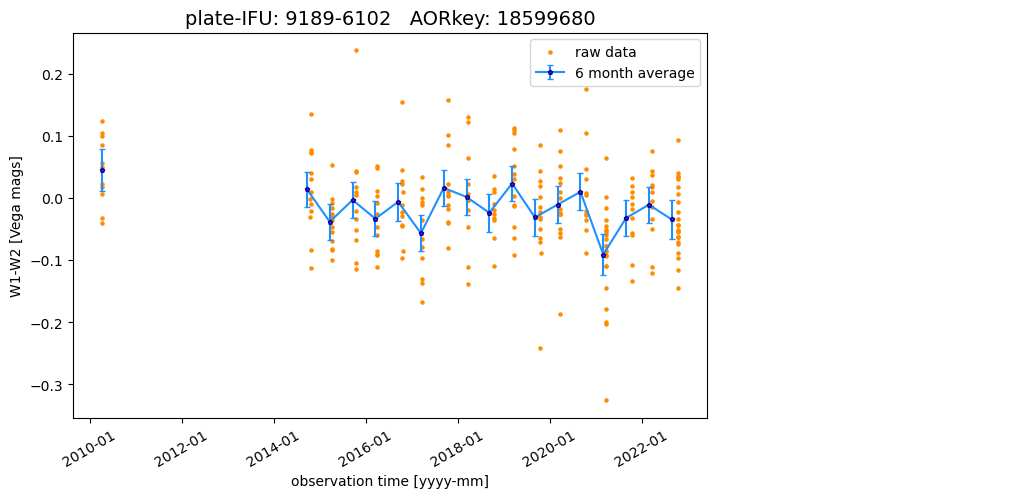

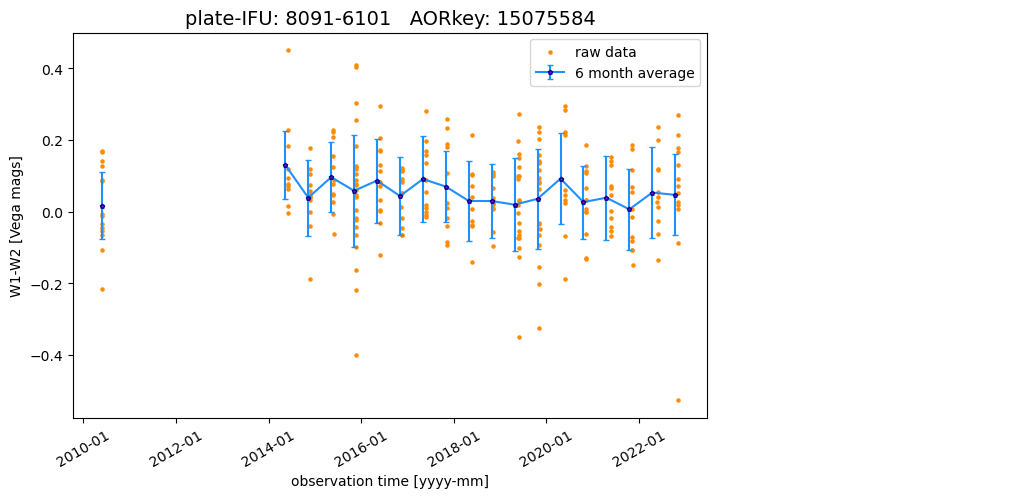

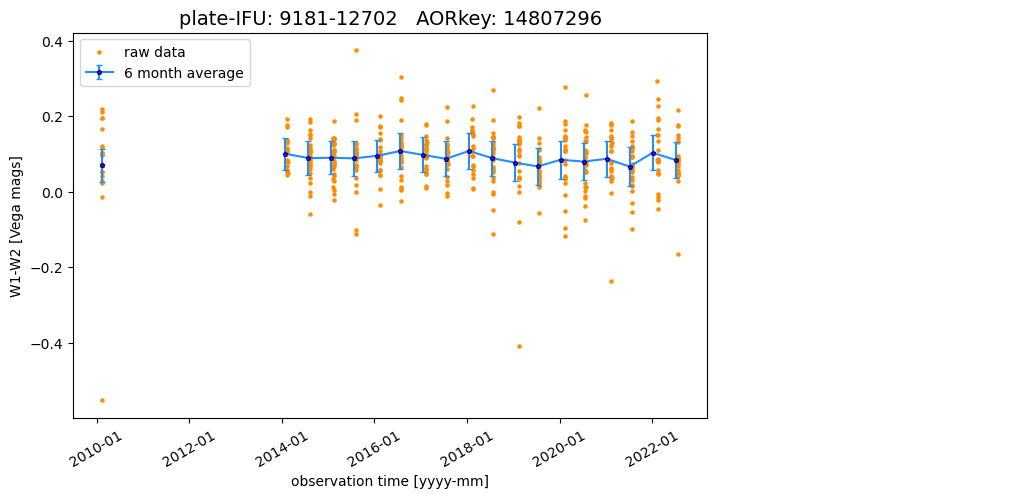

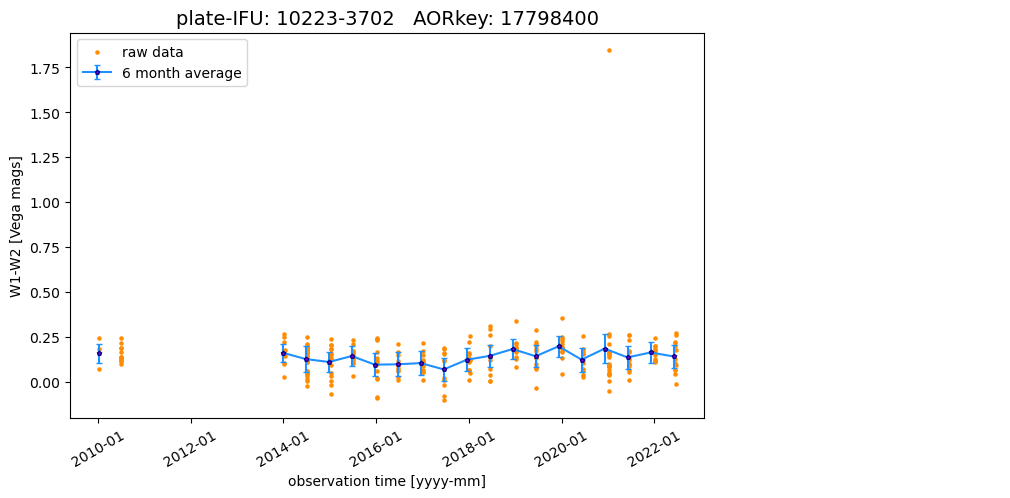

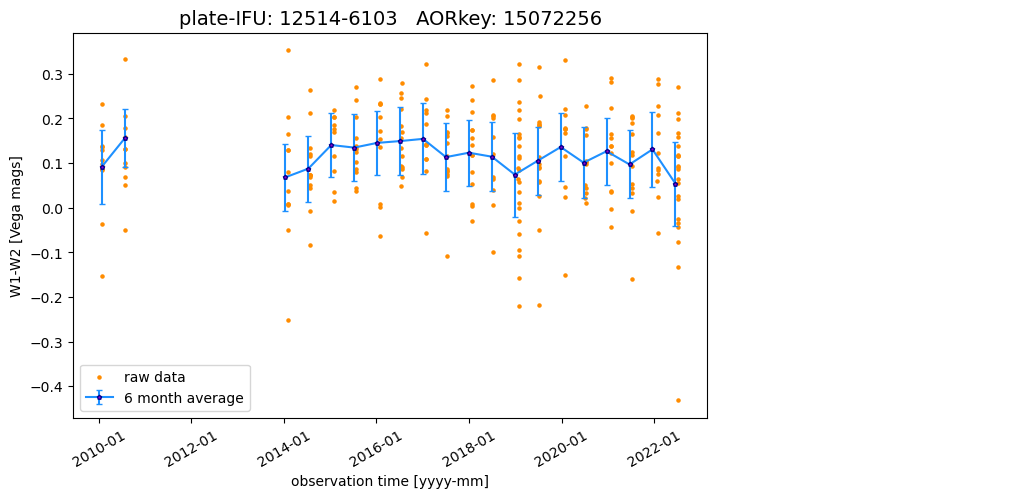

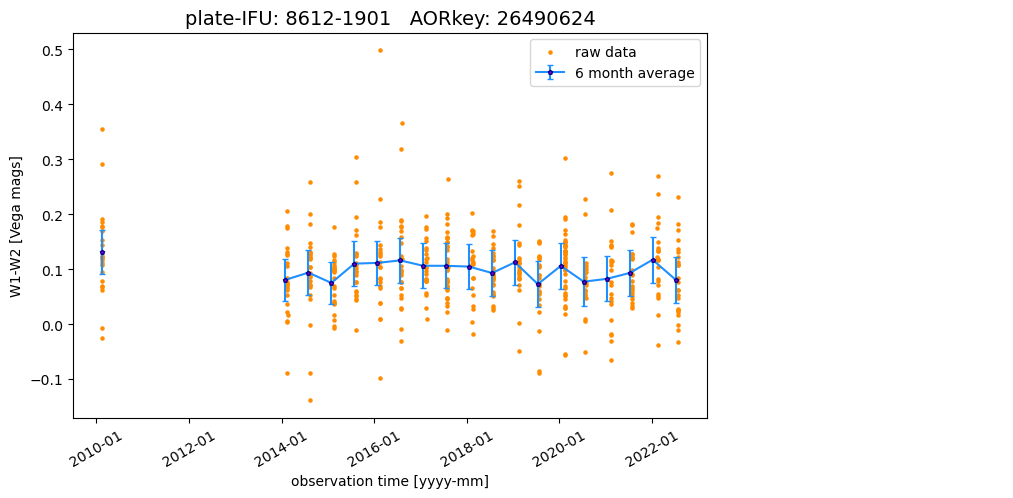

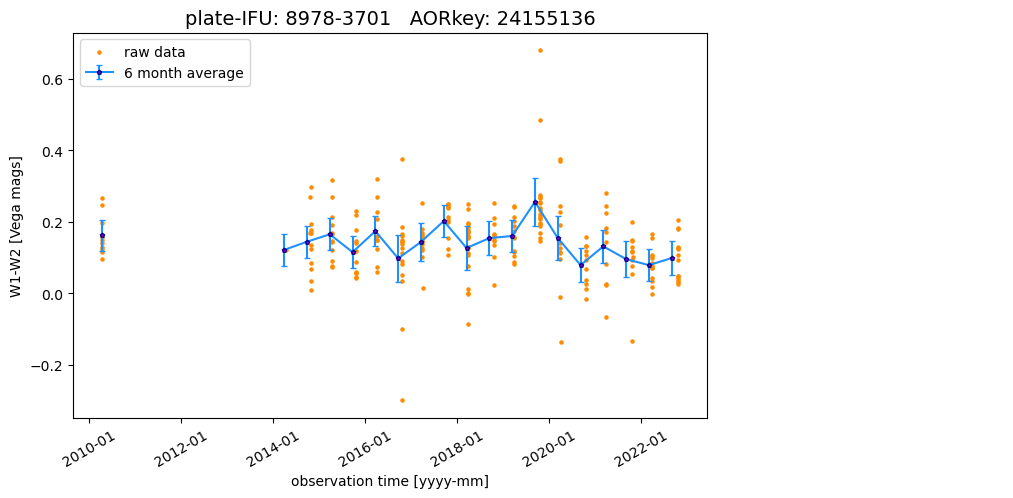

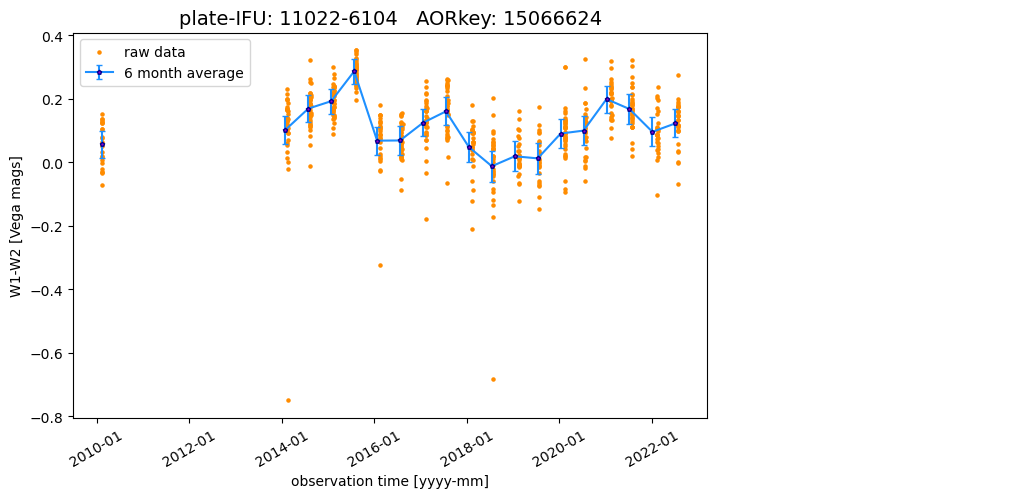

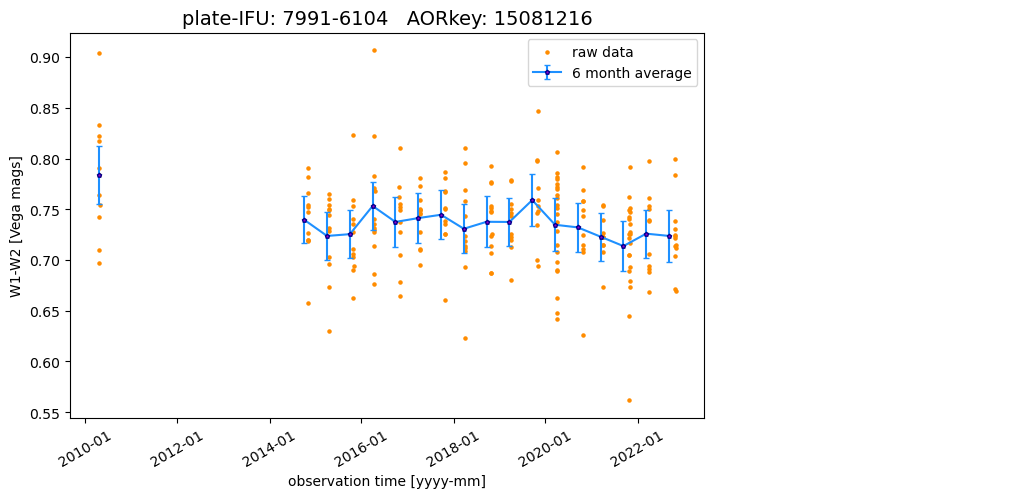

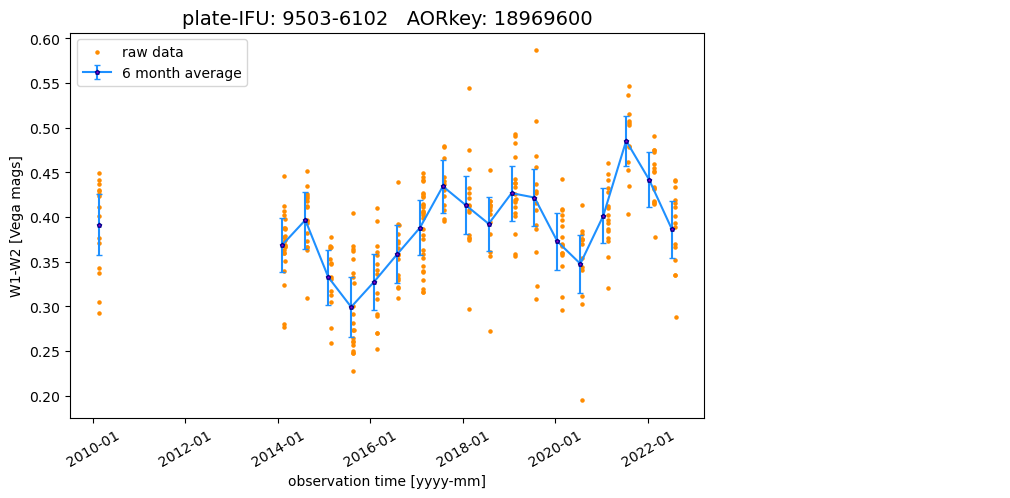

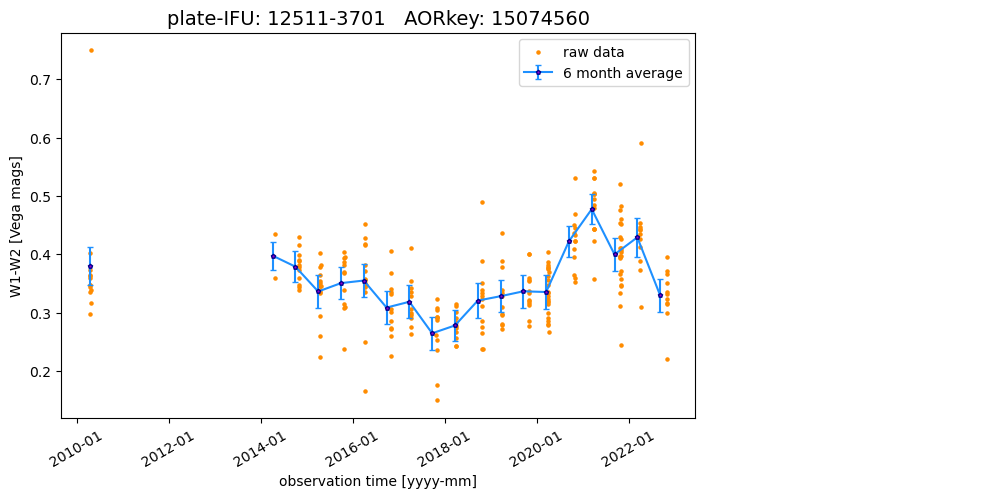

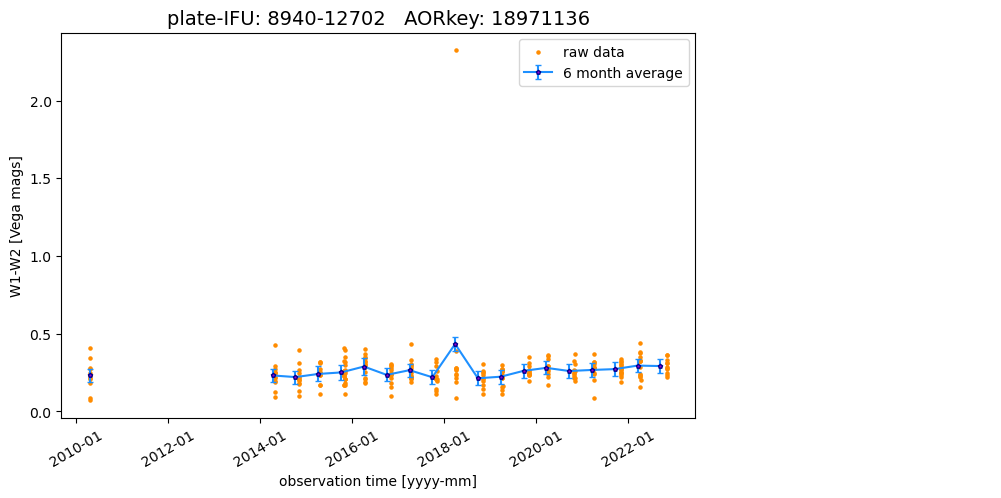

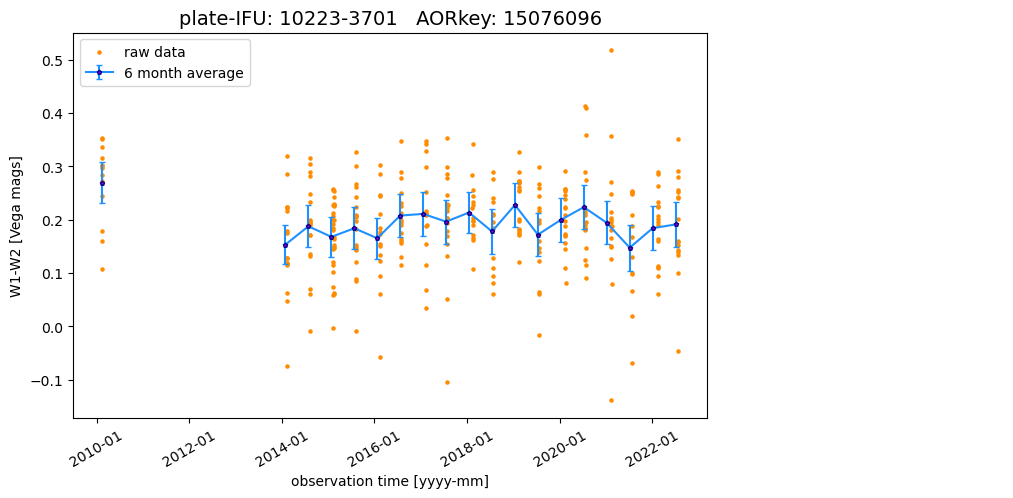

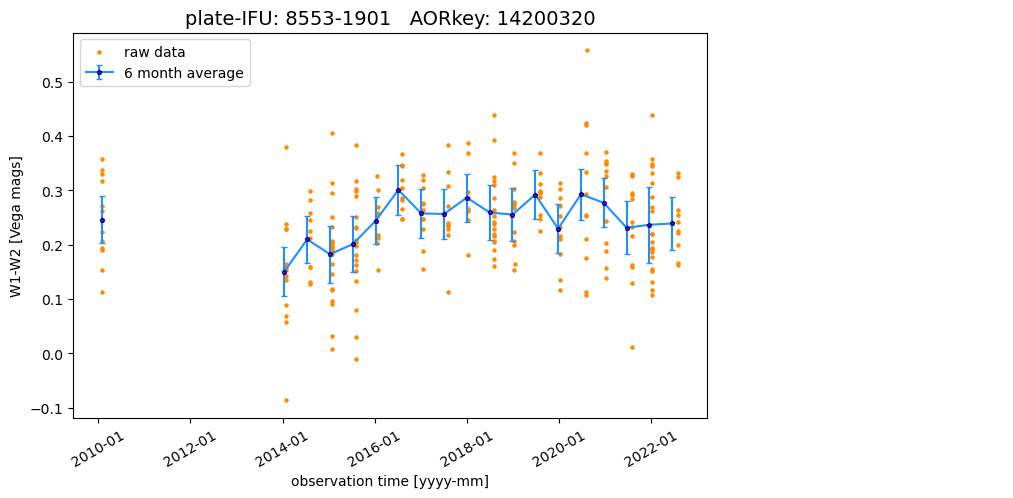

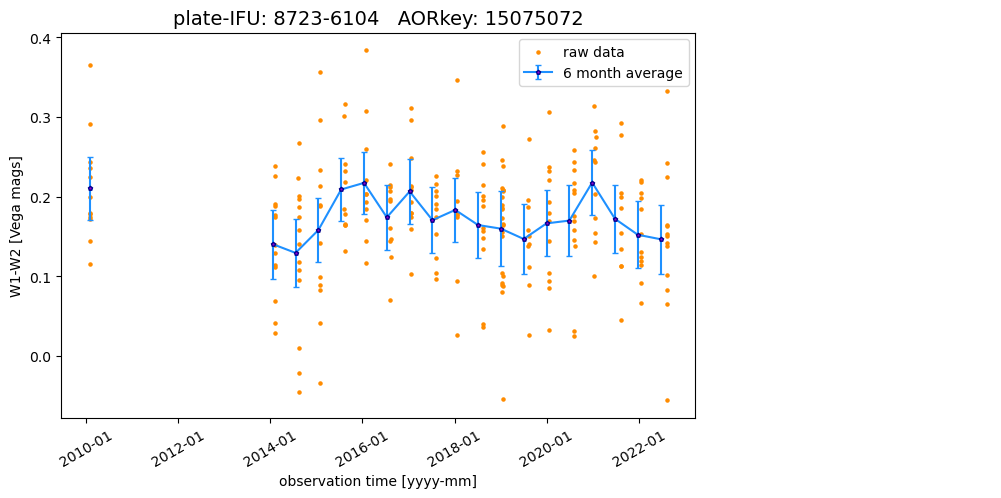

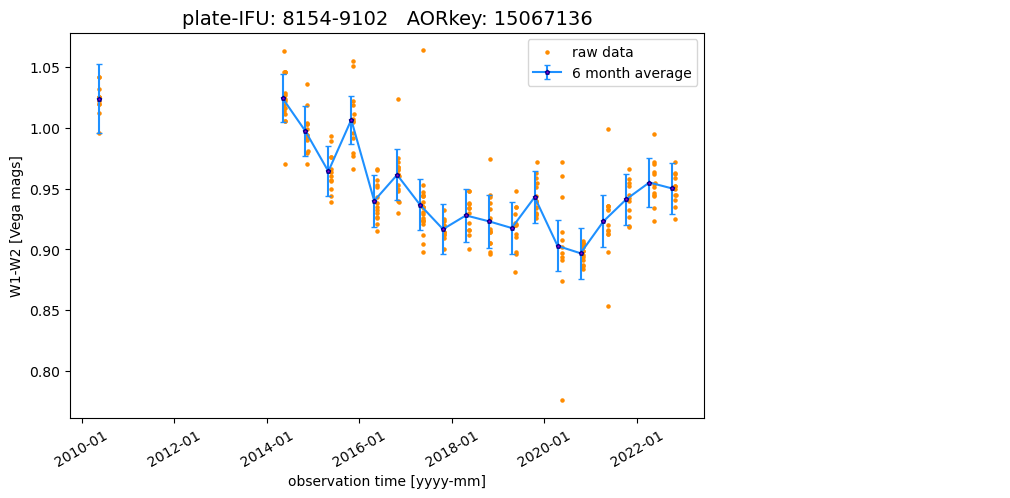

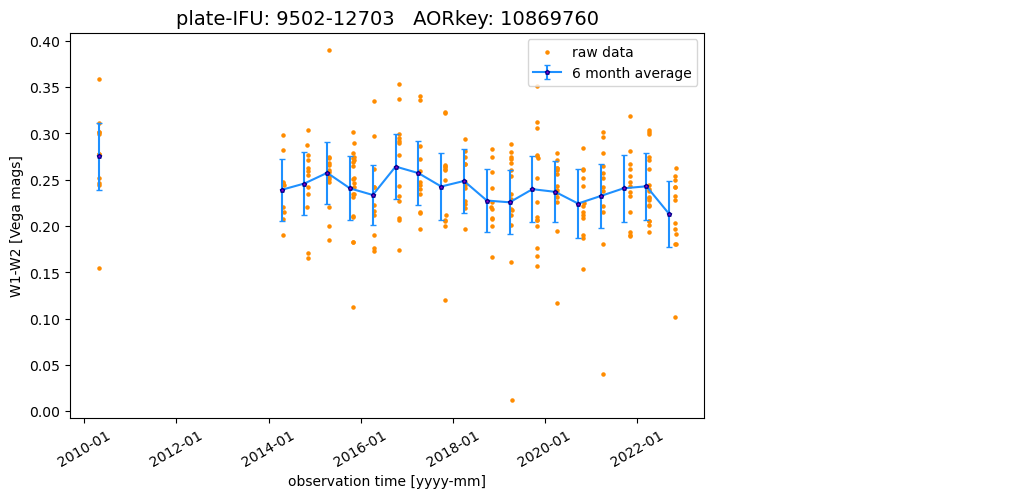

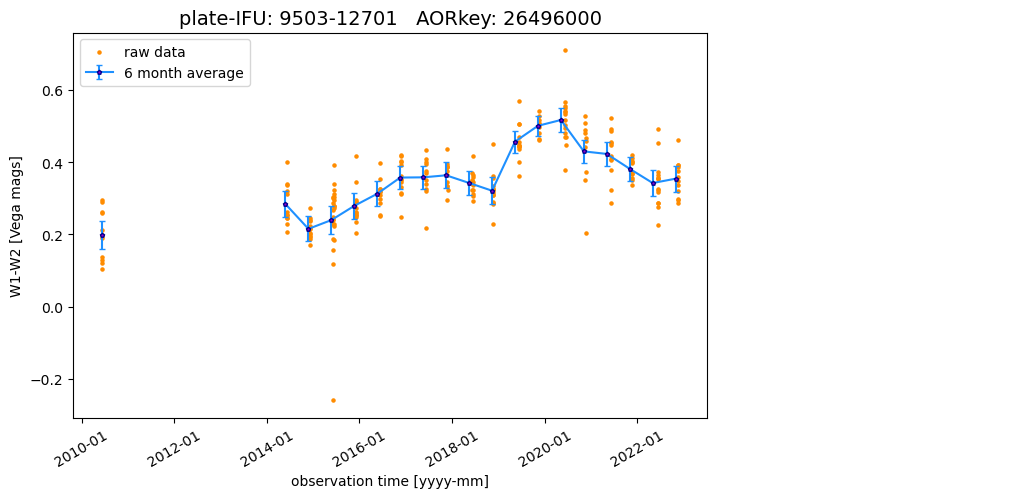

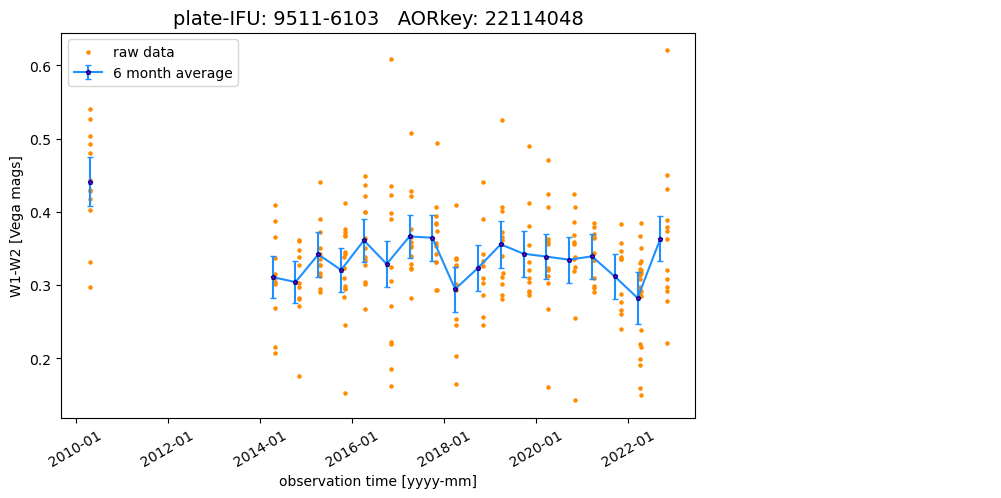

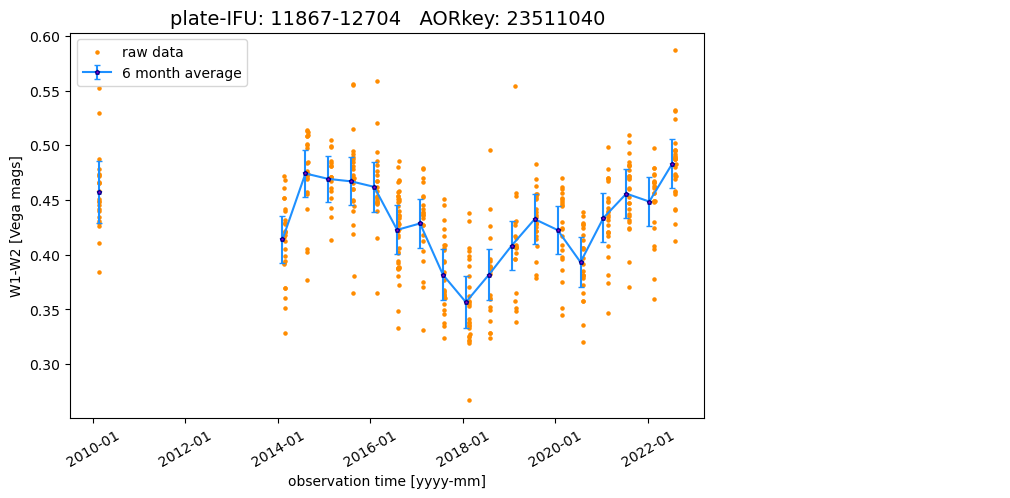

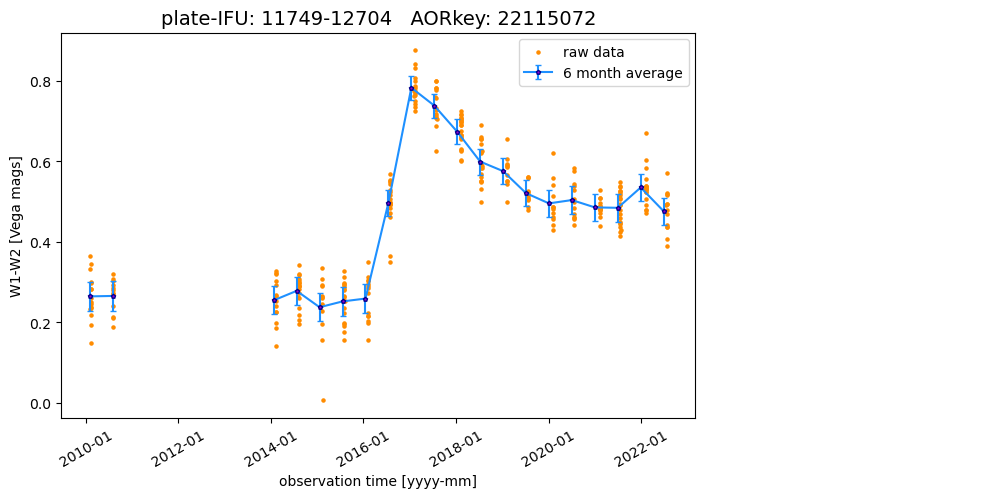

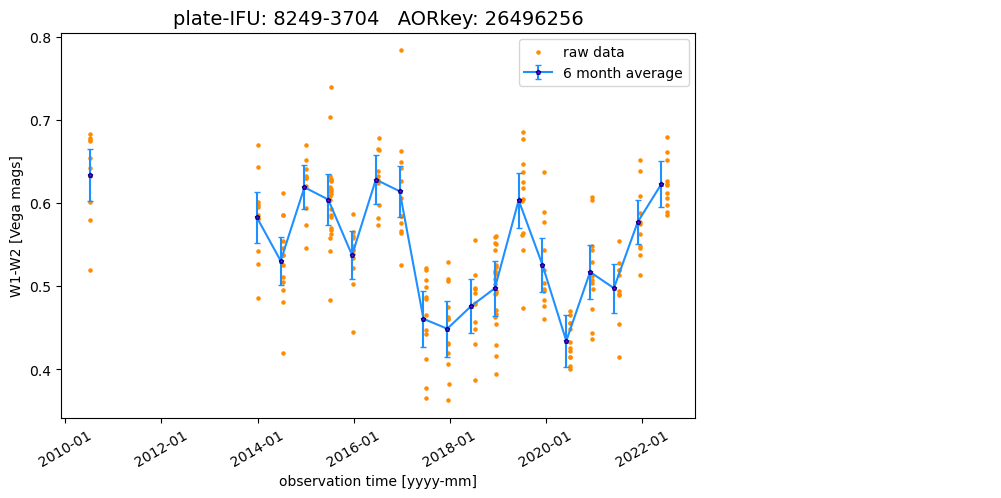

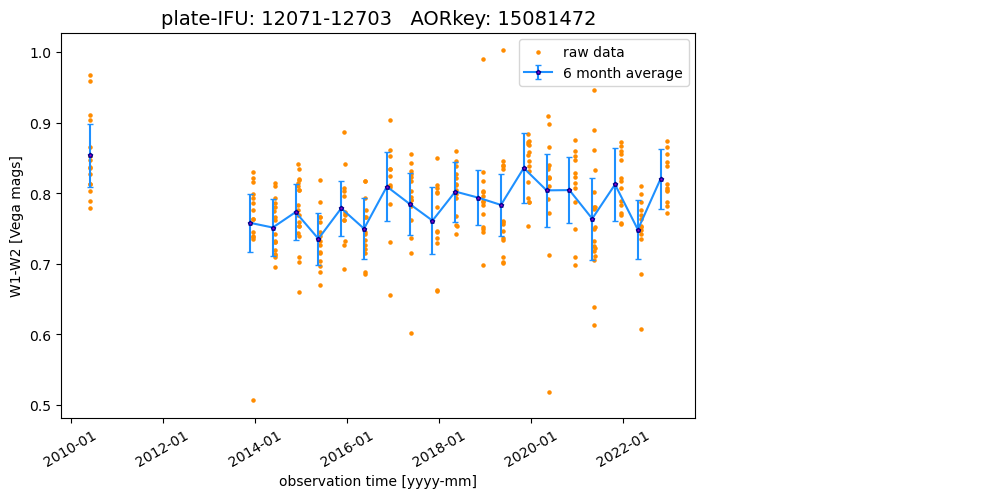

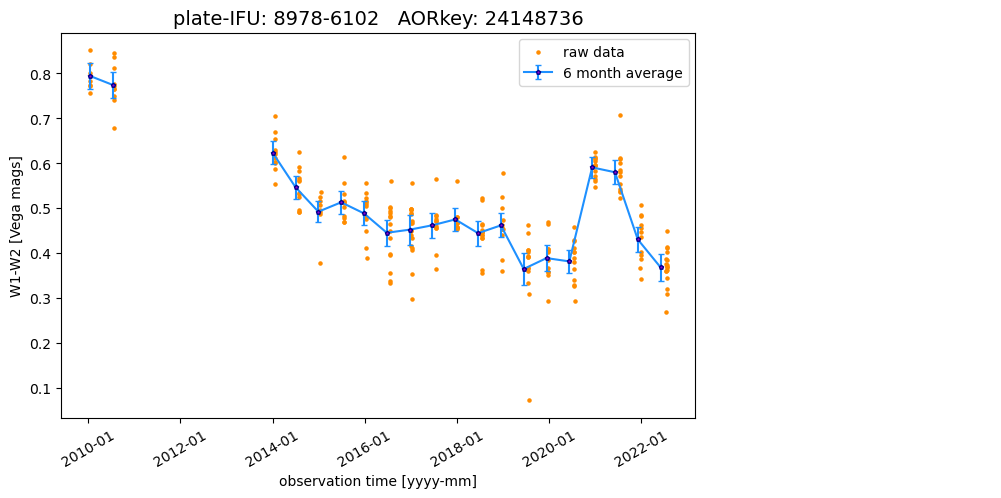

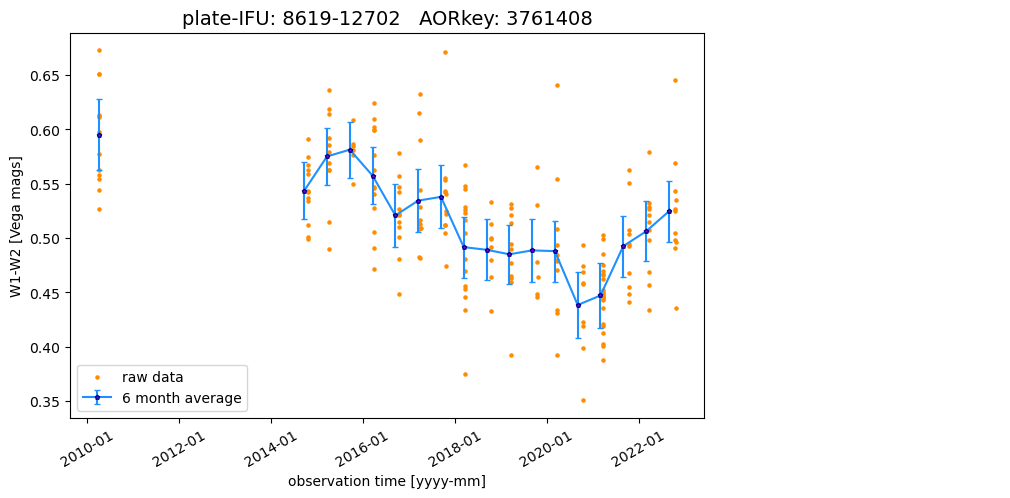

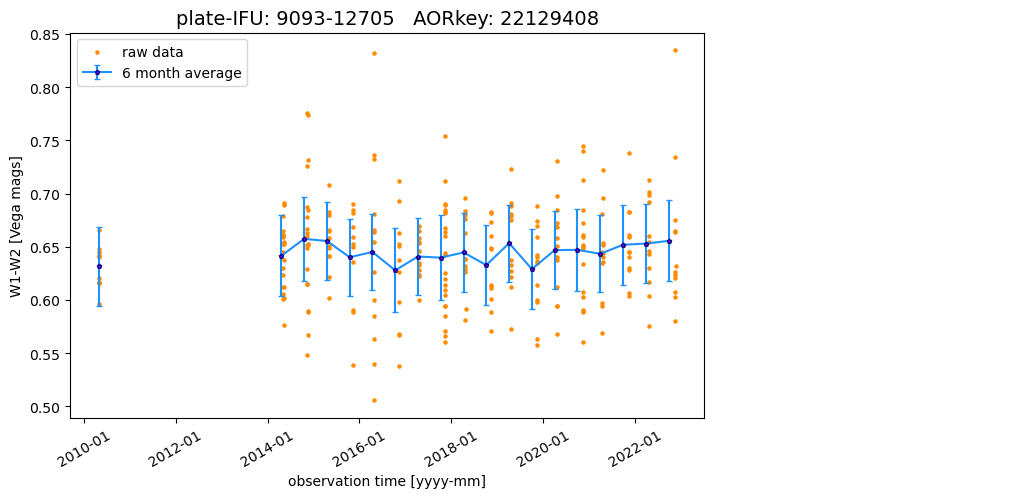

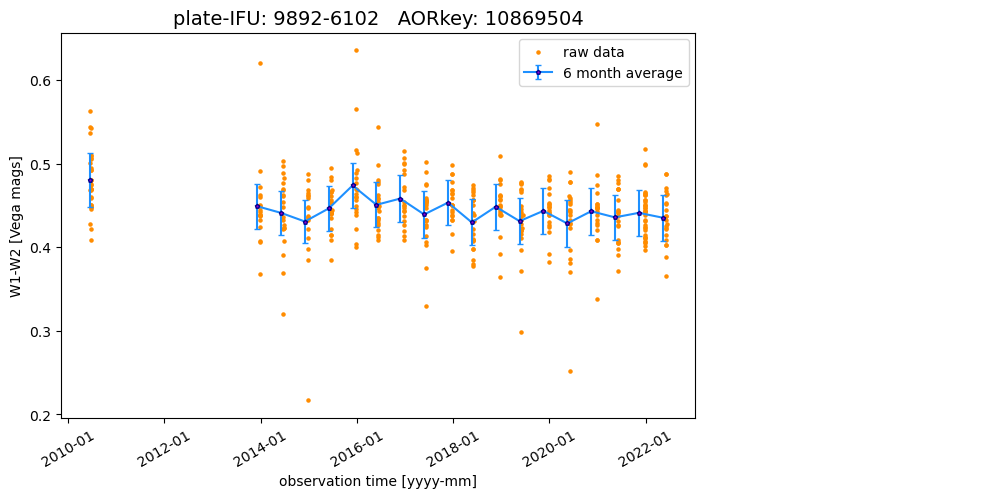

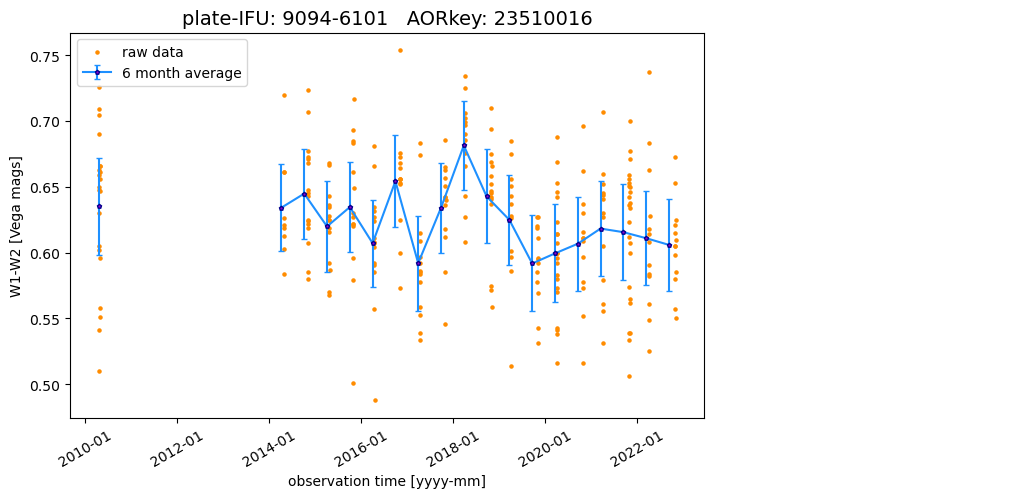

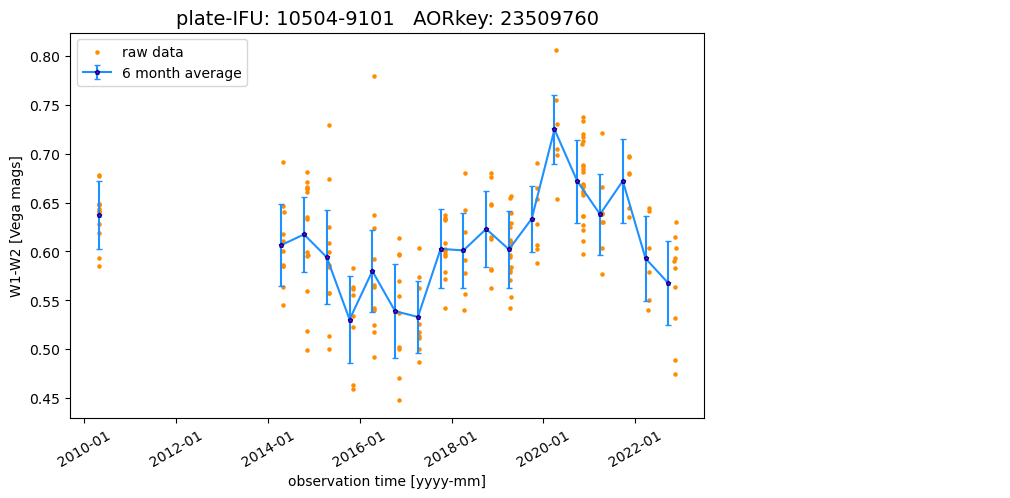

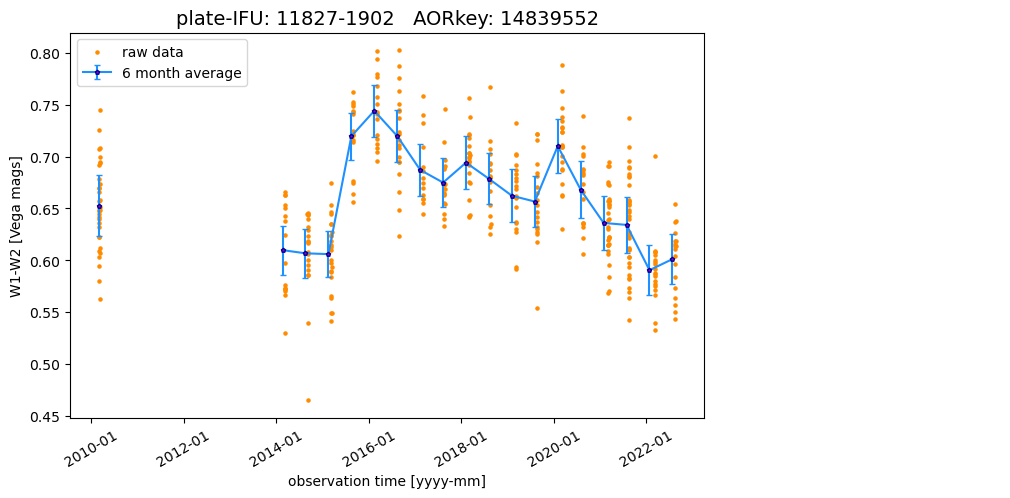

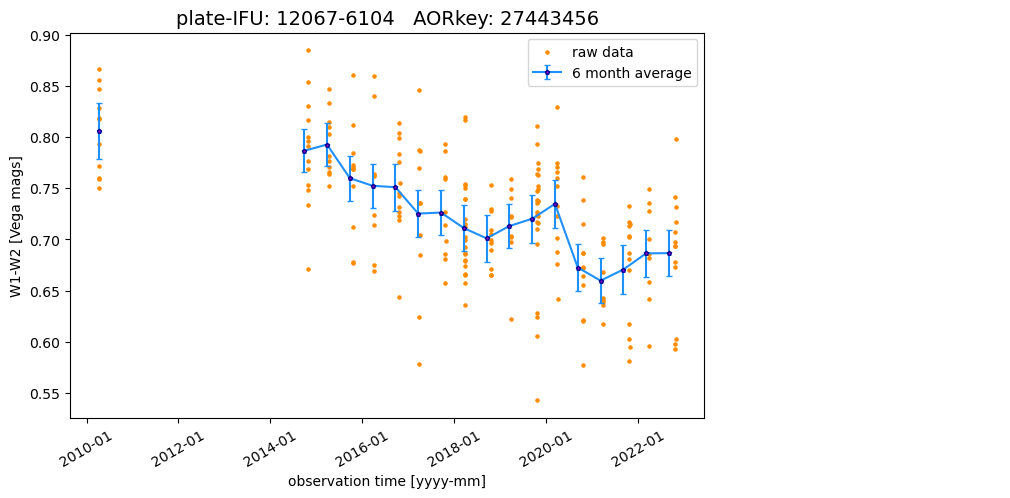

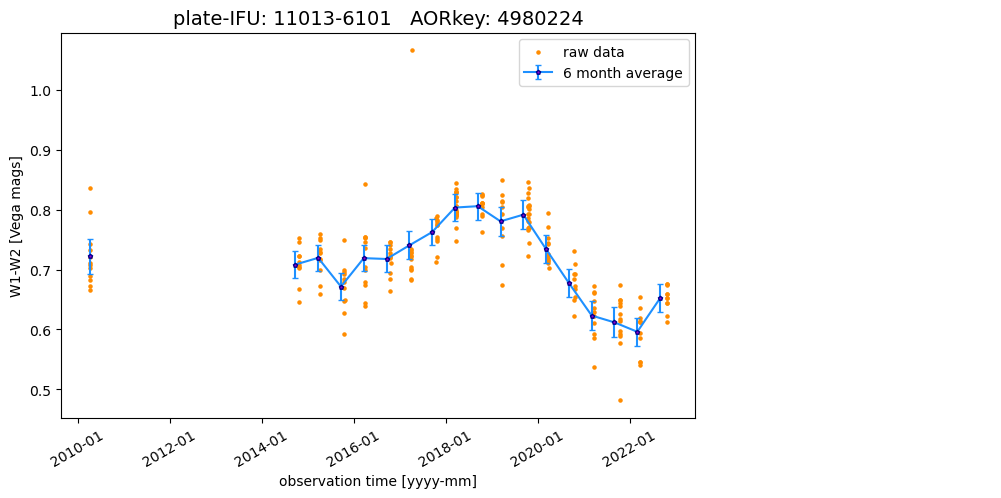

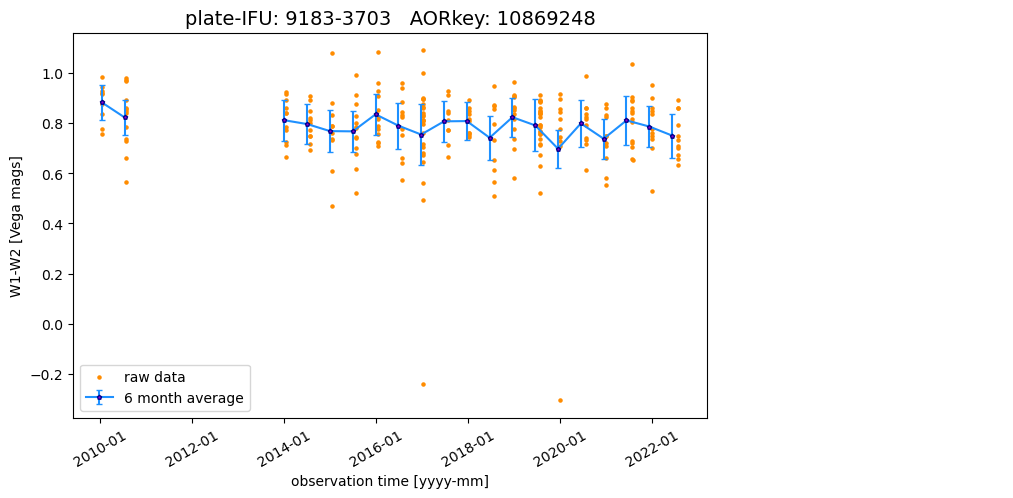

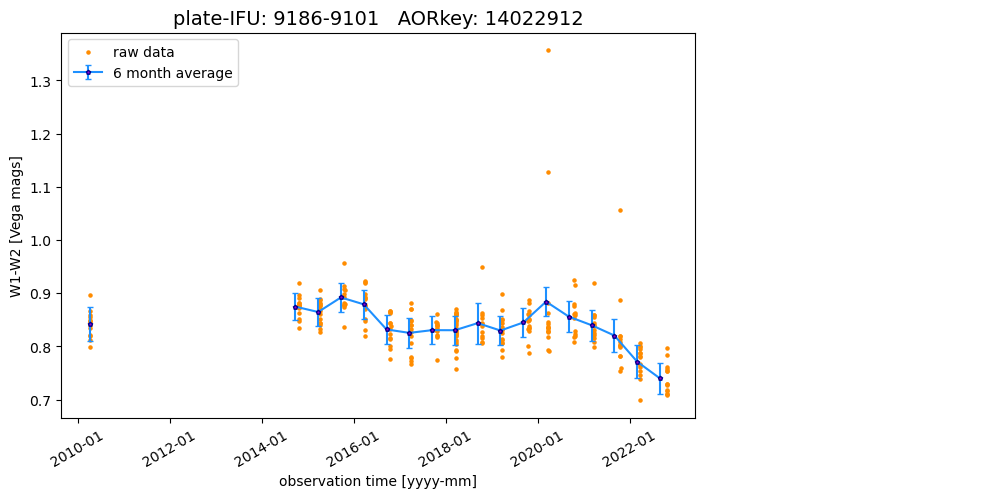

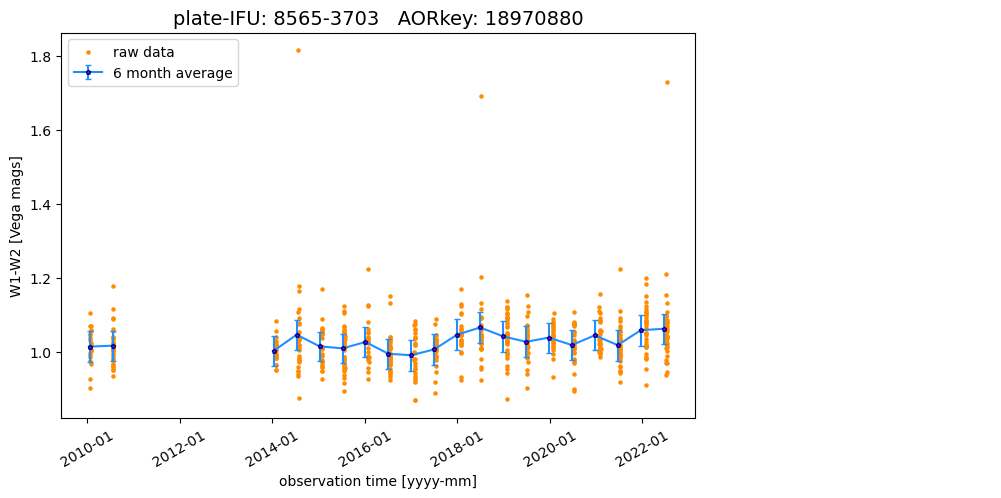

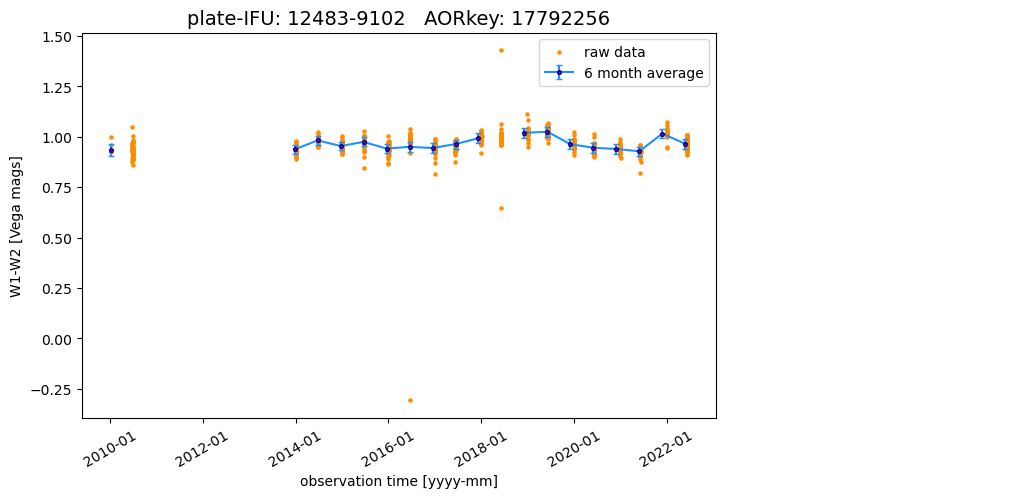

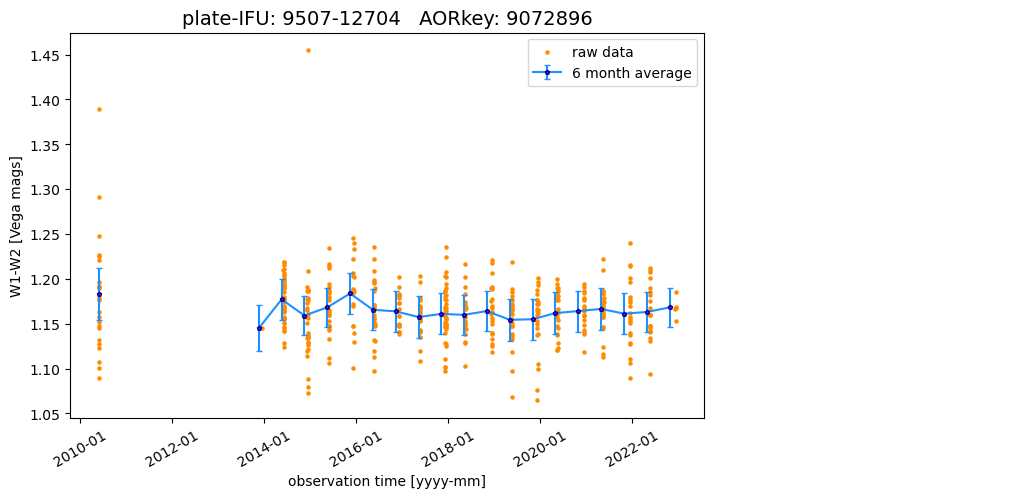

In [18]:
#iterating through each selected object
for i in range(wise_data['cntr_01'].max()):
    
    #creating two dataframes: 'objects' contains all data related to one object, 'avg' contains resampled data
    avg = wise_data_avg[wise_data_avg['cntr_01'] == i + 1]
    objects = wise_data[wise_data['cntr_01'] == i + 1]
    
    #plotting W1-W2 (average and raw data)
    fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
    axa, axb = ax
    
    axa.errorbar(avg['date'], avg['w1mpro-w2mpro'], yerr = avg['w12sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'dodgerblue', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = '6 month average')
    axa.scatter(objects['date'], objects['w1mpro-w2mpro'], s = 5, color = 'darkorange', label = 'raw data')

    #formatting x axis to dates
    xfmt = mdates.DateFormatter('%Y-%m')
    axa.xaxis.set_major_formatter(xfmt)
    axa.tick_params(axis = 'x', labelrotation=30)
    
    #plot label
    axb.axis('off')
    axa.set_ylabel('W1-W2 [Vega mags]')
    axa.set_xlabel('observation time [yyyy-mm]')
    axa.set_title('plate-IFU: ' + str(galaxy_data['plateifu'].to_numpy()[i]) + '   AORkey: ' + str(galaxy_data['aorkey'].to_numpy()[i]), fontsize = 14)
    axa.legend()
    
    #plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + str(galaxy_data['plateifu'].to_numpy()[i]) + '_WISE_W1-W2.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

### Plotting trend of W2

### a) Mean Magnitude in each epoch

C:\Users\paiaa\AppData\Local\Temp\ipykernel_29752\1614052374.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})


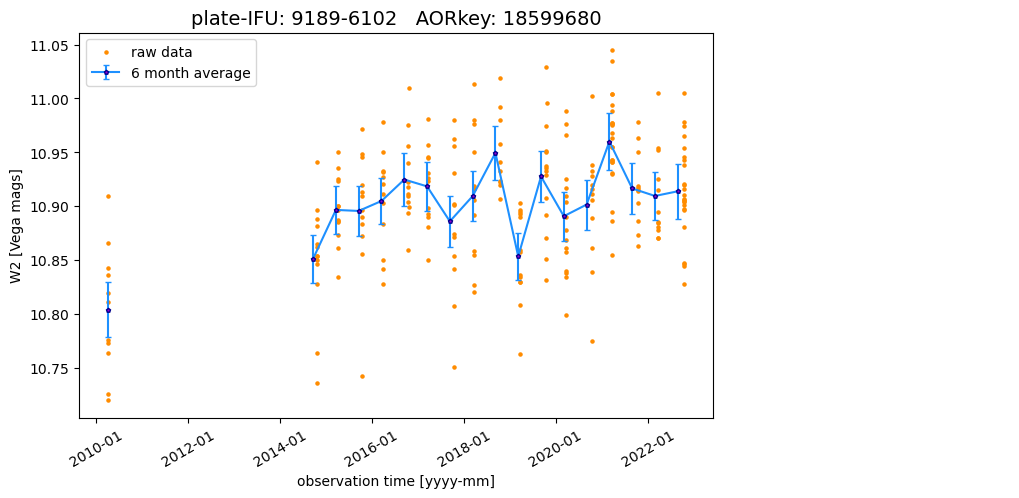

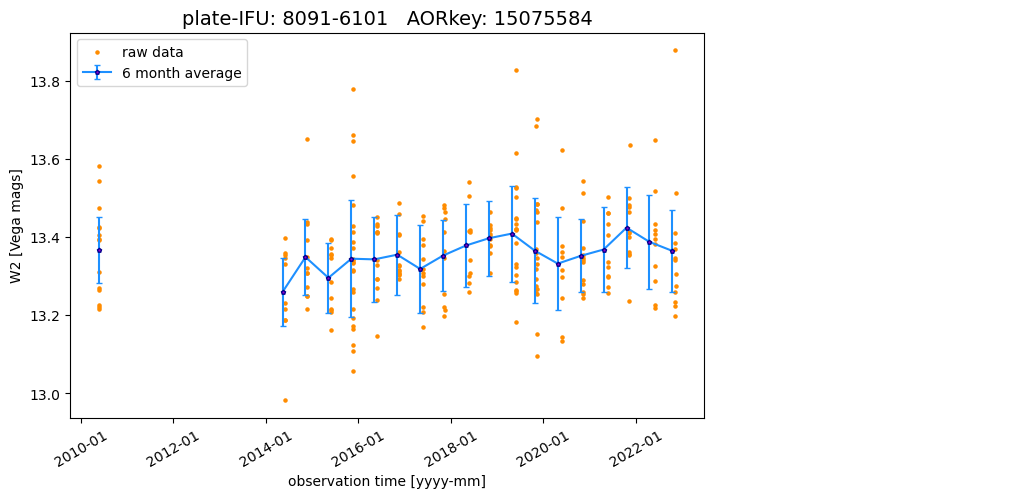

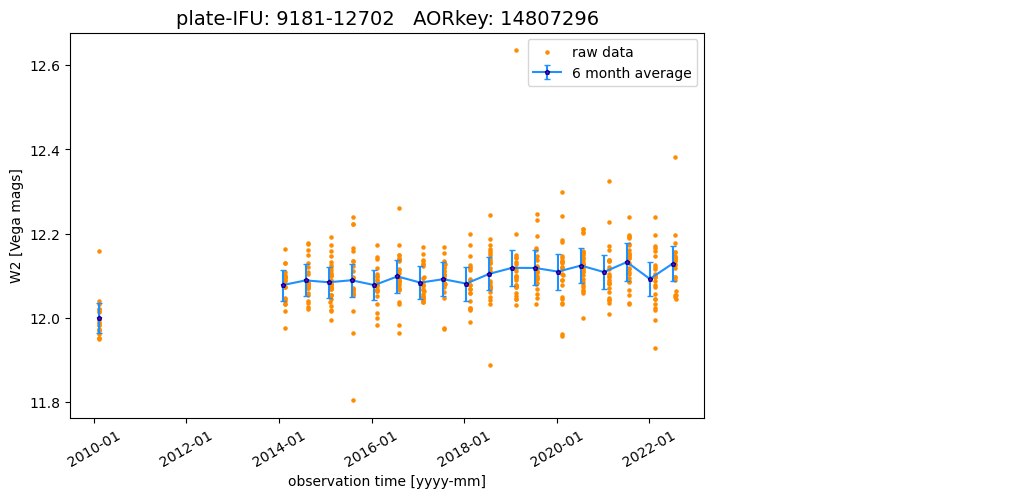

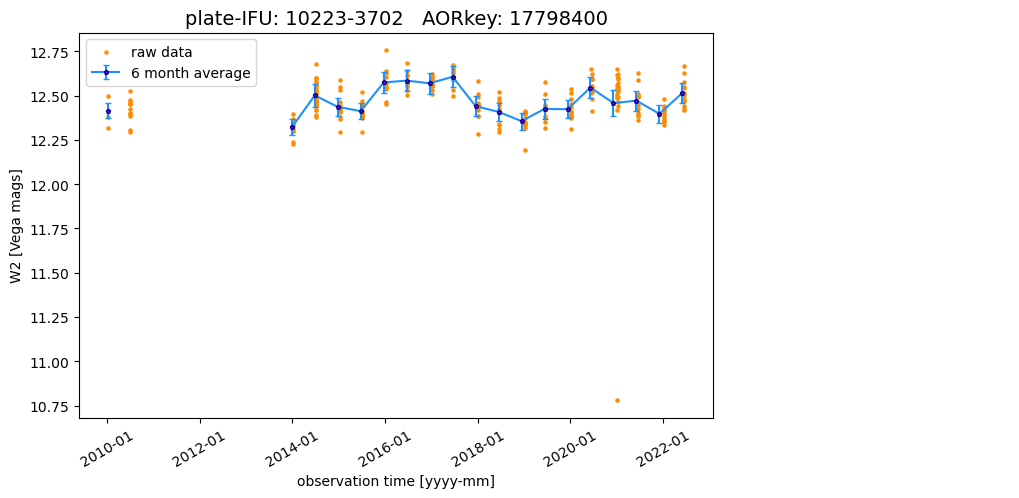

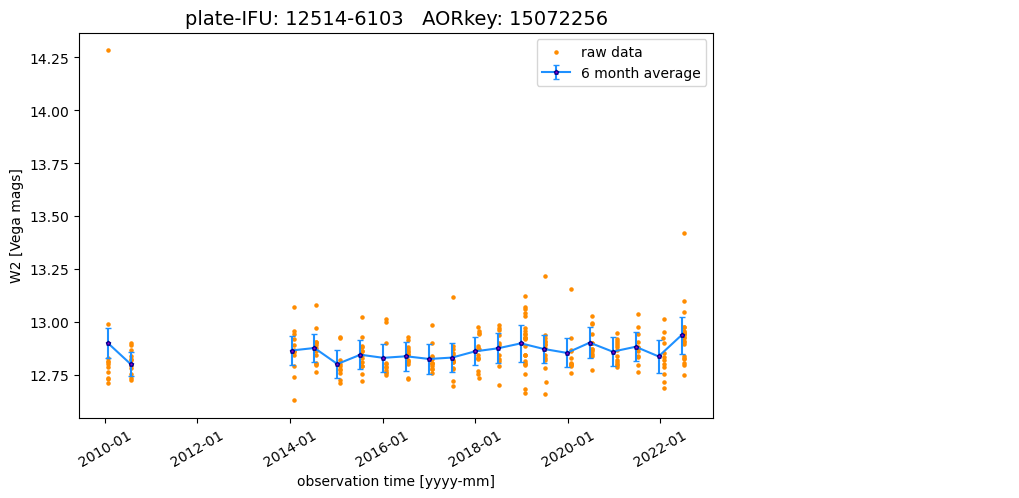

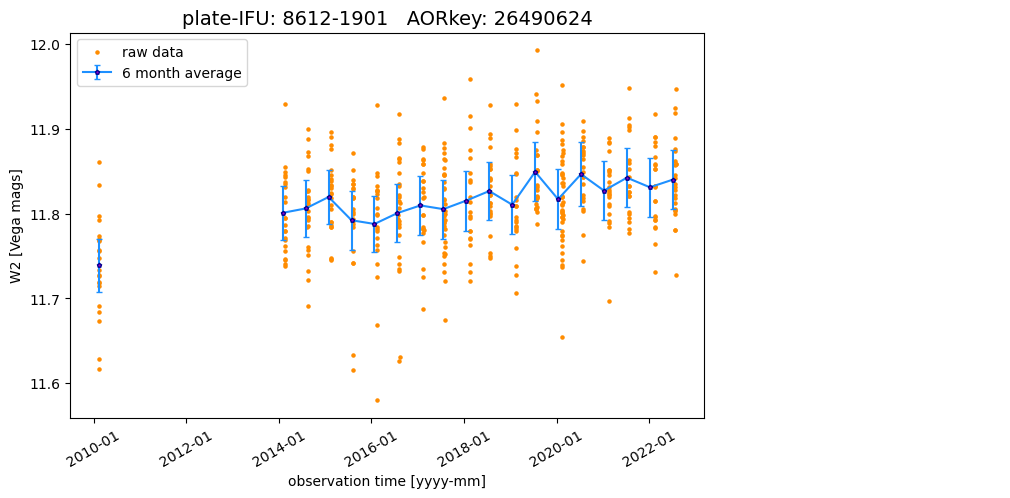

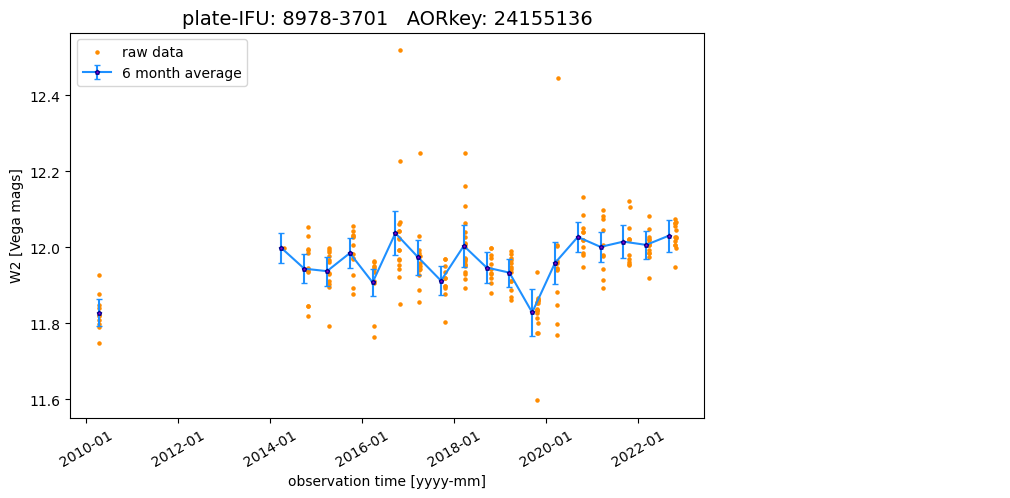

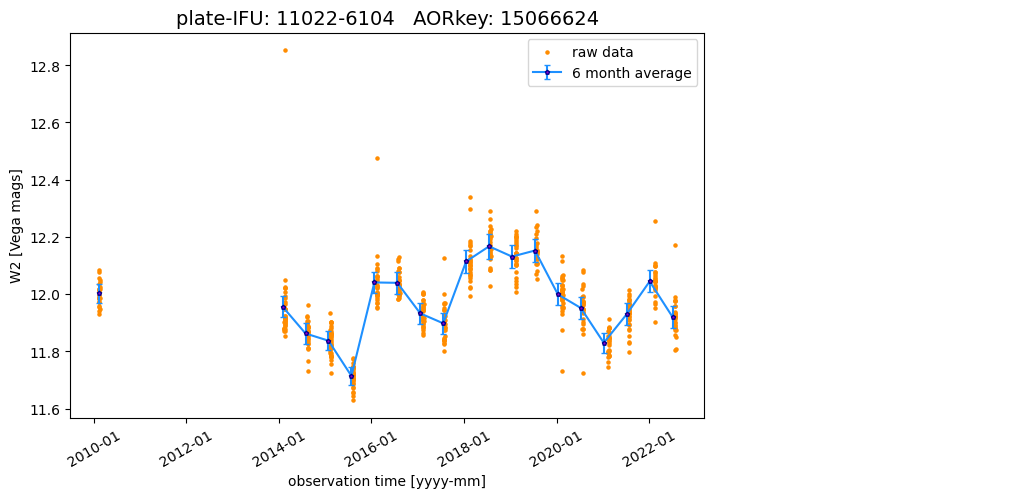

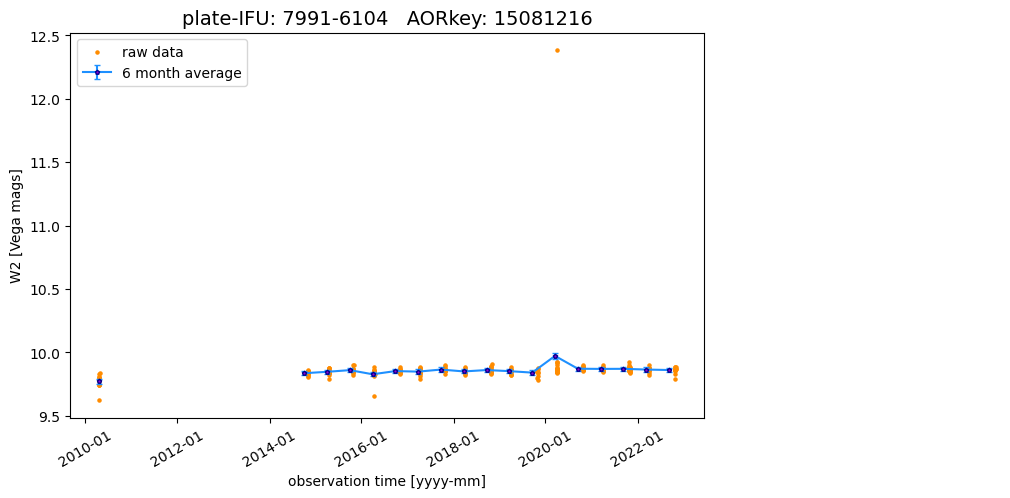

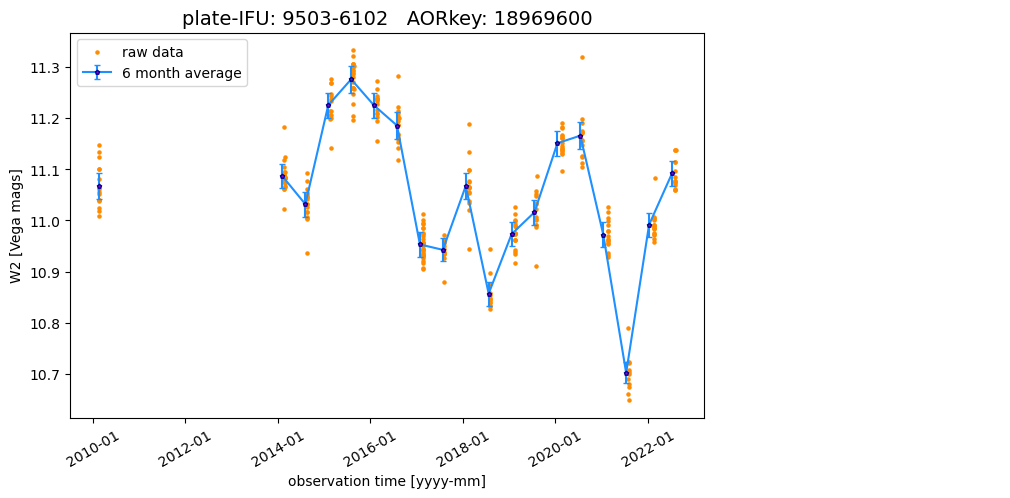

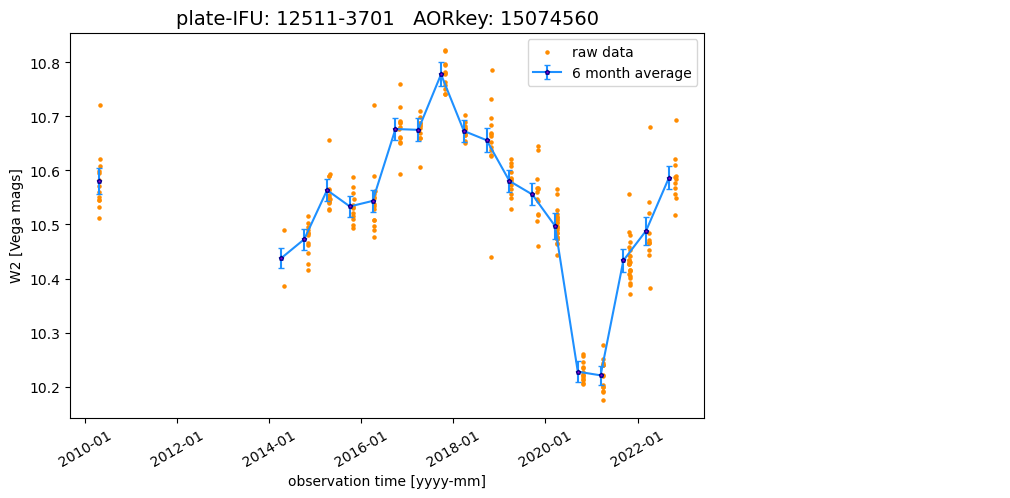

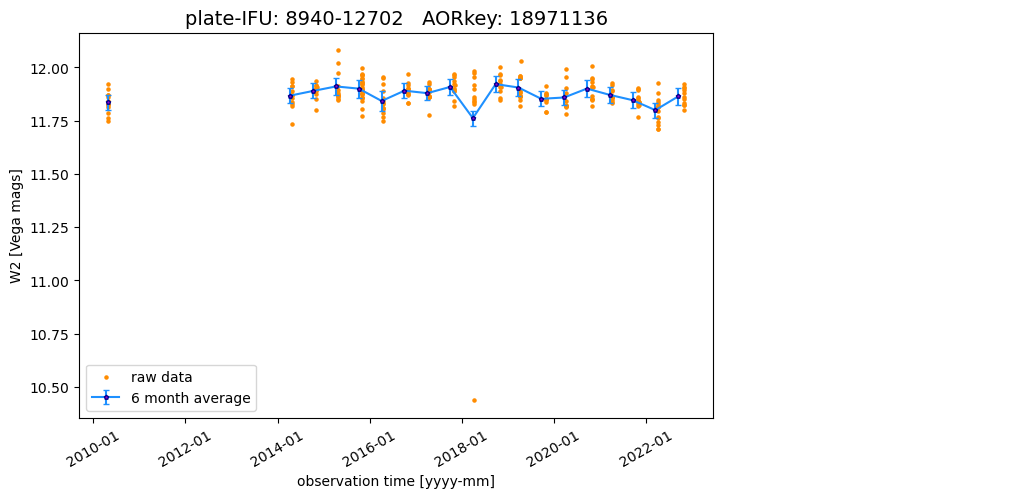

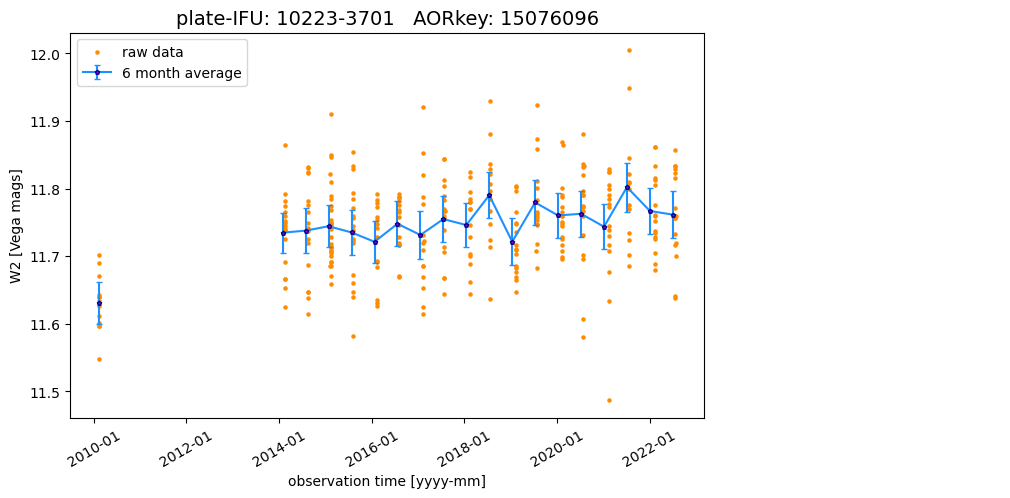

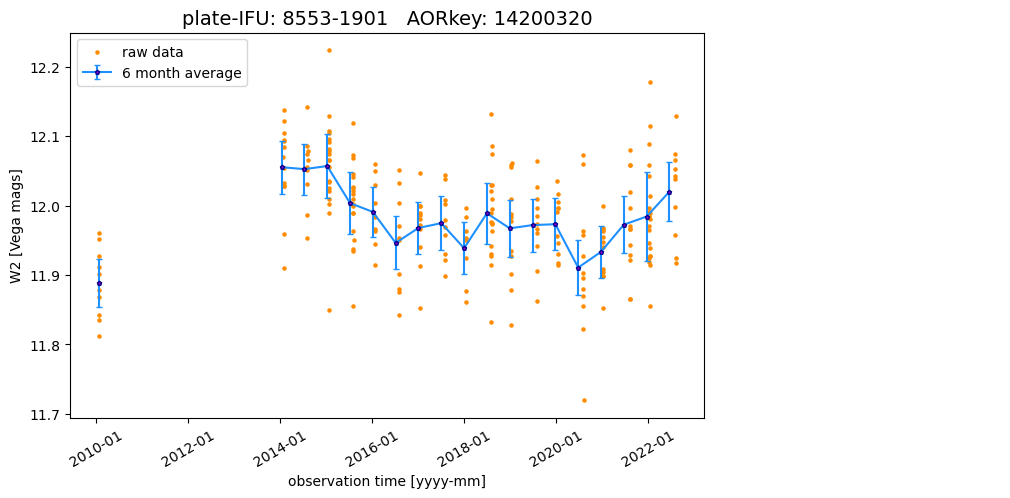

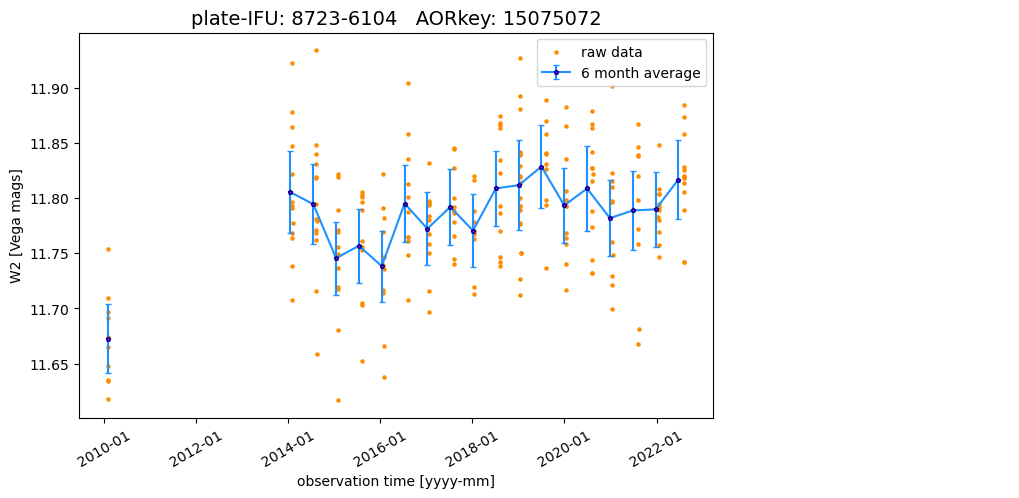

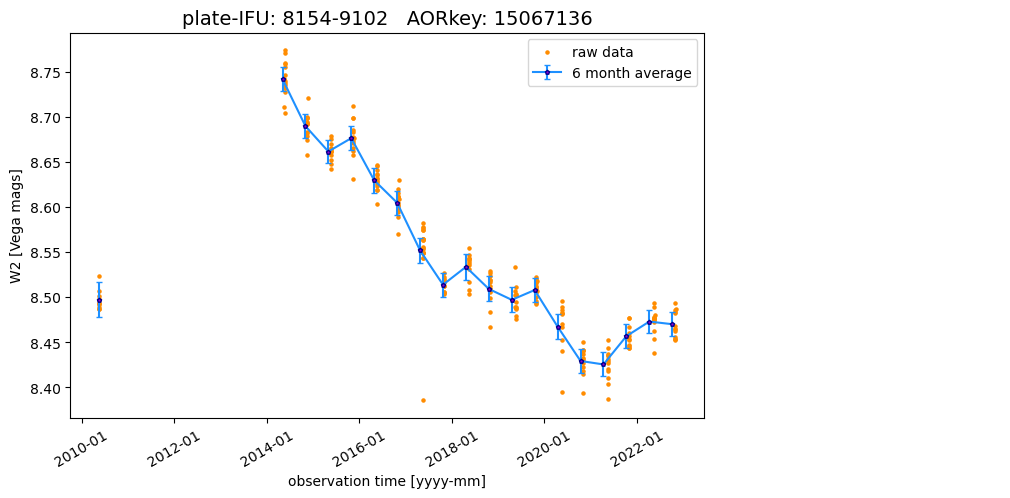

In [ ]:
for i in range(wise_data['cntr_01'].max()):
    objects = wise_data[wise_data['cntr_01'] == i+1]
    avg = wise_data_avg[wise_data_avg['cntr_01'] == i+1]
    
    #plotting W2 (average and raw data)
    fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
    axa, axb = ax
    axa.errorbar(avg['date'], avg['w2mpro'], yerr = avg['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'dodgerblue', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = '6 month average')
    axa.scatter(objects['date'], objects['w2mpro'], s = 5, color = 'darkorange', label = 'raw data')
    #axa.errorbar(var_mean['date'], var_mean['w2mpro'], yerr = var_mean['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'green', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = 'mean of variance')
    
    #formatting x axis to dates
    xfmt = mdates.DateFormatter('%Y-%m')
    axa.xaxis.set_major_formatter(xfmt)
    axa.tick_params(axis = 'x', labelrotation=30)
    
    #plot label
    axb.axis('off')
    axa.set_ylabel('W2 [Vega mags]')
    axa.set_xlabel('observation time [yyyy-mm]')
    axa.set_title('plate-IFU: ' + str(galaxy_data['plateifu'].to_numpy()[i]) + '   AORkey: ' + str(galaxy_data['aorkey'].to_numpy()[i]), fontsize = 14)
    axa.legend()
    #plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + str(galaxy_data['plateifu'].to_numpy()[i]) + '_WISE_W2.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

### b) variance within each epoch expected from the uncertainties

### c) observed variance within each epoch

### d) mean squared error (MSE) in mean

In [ ]:
def MSE_per_epoch(objects):
    mse = np.array([])
    
    for j in range(objects['epoch'].max()- objects['epoch'].min()):
        
        per_epoch = objects[objects['epoch'] == j+objects['epoch'].min()]
        
        w2mpro = per_epoch['w2mpro'].to_numpy()
        w2sigmpro = per_epoch['w2sigmpro'].to_numpy()
        
        w2 = unp.uarray(w2mpro, w2sigmpro)
        
        if w2.shape[0] > 0:
            mean = np.mean(w2)
            sigma_squared = (w2 - mean) ** 2
            MSE = np.sum(sigma_squared)/sigma_squared.shape[0] ** 2
            mse = np.append(mse, MSE.nominal_value)
        else:
            mse = np.append(mse, np.nan)
    return mse

In [ ]:
avg_mse = np.array([])
for i in range(wise_data['cntr_01'].max()):
    objects = wise_data[wise_data['cntr_01'] == i+1]
    
    
    mse = MSE_per_epoch(objects)
        
    avg = np.nanmean(mse)
    avg_mse = np.append(avg_mse, avg)
        

### e) observed variance across all epochs

In [ ]:
observed_var_of_mean = np.array([])
for i in range(wise_data['cntr_01'].max()):
    #mean at each epoch
    objects = wise_data[wise_data['cntr_01'] == i+1]
    
    avg = wise_data_avg[wise_data_avg['cntr_01'] == i+1]
    
    observed_var_of_mean = np.append(observed_var_of_mean, avg['w2mpro'].var())


In [ ]:
AGN_candidates = np.log10(observed_var_of_mean)
AGN_candidates[AGN_candidates < -2.1] = 0
AGN_candidate_cntr01 = np.where(AGN_candidates != 0)[0] + 1
AGN_candidate_cntr01

In [ ]:
print(observed_var_of_mean.shape[0])
print(avg_mse.shape[0])

### comparing b) and c)

In [ ]:
uncertainty_var = wise_data_avg
observed_var = wise_data_var

fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
axa, axb = ax
axa.plot(np.linspace(-4,-1.5,100),np.linspace(-4,-1.5,100), color = 'blue', linewidth = 1.5, label = 'y = x')
axa.scatter(np.log10(uncertainty_var['error squared']), np.log10(observed_var['w2mpro']), s = 10, alpha = 0.5, color = 'darkorange')
axa.plot(np.linspace(-4,-1.5,100), -2*np.ones(100), color = 'gray', linestyle = 'dashed', label = 'AGN cutoff')
#axa.scatter(observed_var['date'], s = 10, color = 'darkorange', label = 'observed variance')
#axa.errorbar(var_mean['date'], var_mean['w2mpro'], yerr = var_mean['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'green', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = 'mean of variance')

#plot label
axa.set_xlim(-4,-1.5)
axb.axis('off')
axa.set_ylabel('$\log(\sigma^2_{W2})$ (per epoch) [Vega mags]')
axa.set_xlabel('$\log(\sigma^2_{err})$ (per epoch) [Vega mags]')
axa.set_title('Observed Var(W2) vs. Expected Var(W2)', fontsize = 14)
axa.legend()
#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + 'mean_reported_var_vs_observed_var_per_epoch_flagged.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [ ]:
for i in range(wise_data['cntr_01'].max()):
    
    uncertainty_var = wise_data_avg[wise_data_avg['cntr_01'] == i+1]
    observed_var = wise_data_var[wise_data_var['cntr_01'] == i+1]
    
    fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
    axa, axb = ax
    axa.plot(np.log10(np.linspace(0.0001, 0.1, 100)),np.log10(np.linspace(0.0001, 0.1, 100)), color = 'blue', linewidth = 1.5, label = 'y = x')
    axa.scatter(np.log10(uncertainty_var['error squared']), np.log10(observed_var['w2mpro']), s = 10, color = 'darkorange')
    axa.plot(np.linspace(-4,-1.5,100), -2*np.ones(100), color = 'gray', linestyle = 'dashed')
    #plot label
    axa.set_xlim(-4,-1.5)
    axb.axis('off')
    axa.set_ylabel('$\log(\sigma^2_{W2})$ (per epoch) [Vega mags]')
    axa.set_xlabel('$\log(\sigma^2_{err})$ (per epoch) [Vega mags]')
    axa.set_title('plate-IFU: ' + str(galaxy_data['plateifu'].to_numpy()[i]) + '   AORkey: ' + str(galaxy_data['aorkey'].to_numpy()[i]), fontsize = 14)
    axa.legend()
    #plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\Error Analysis\\' + galaxy_data['plateifu'].to_numpy()[i] + 'observed_var_vs_expected_var.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [ ]:
uncertainty_var = wise_data_avg
observed_var = wise_data_var

fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
axa, axb = ax
axa.plot(np.linspace(-4.5, 0, 100),np.linspace(-4.5, 0, 100), color = 'blue', linewidth = 1, label = 'y = x')
axa.scatter(np.log10(wise_data_var['w1mpro-w2mpro']), np.log10(observed_var['w2mpro']), s = 13, alpha = 0.5, color = 'darkorange')
#axa.plot(np.linspace(-4,-1.5,100), -2*np.ones(100), color = 'gray', linestyle = 'dashed', label = 'AGN cutoff')
#axa.scatter(observed_var['date'], s = 10, color = 'darkorange', label = 'observed variance')
#axa.errorbar(var_mean['date'], var_mean['w2mpro'], yerr = var_mean['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'green', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = 'mean of variance')

#plot label
axa.set_xlim(-4.4,-0.2)
axb.axis('off')
axa.set_xlabel('$\log(\sigma^2_{W1-W2})$ [Vega mags]')
axa.set_ylabel('$\log(\sigma^2_{W2})$ [Vega mags]')
axa.set_title('Var(W2) vs. Var(W1-W2) (observed per epoch)', fontsize = 14)
axa.legend()
#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + 'Var(W2)_vs_Var(W1-W2__observed.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

### comparing d) and e)  

In [ ]:
#fitting line to non-AGN objects (objects below log(mean(W2)) > -2.0)
filtered = np.log10(observed_var_of_mean)
x = np.log10(avg_mse)

#filtering out AGN objects
filtered[filtered > -2.1] = 0
x[filtered == 0] =  0
x = x[x != 0]
filtered = filtered[filtered != 0]

#linear fit
fit = polyfit(x, filtered, 1)
fit

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
axa, axb = ax

axa.scatter(np.log10(avg_mse), np.log10(observed_var_of_mean), s = 10, color = 'coral')
axa.plot(np.linspace(-4.8, -2.7,100), -2*np.ones(100), color = 'cadetblue', linestyle = 'dashed', label = 'AGN cutoff')
axa.plot(np.linspace(-4.8, -2.7,100), fit[0]*np.linspace(-4.8, -2.75,100)+fit[1], color = 'gray', linestyle = 'dashed', label = 'fit')
axa.fill_between(np.linspace(-4.8, -2.7,100), -2*np.ones(100)+ 0, -2*np.ones(100) +3*np.ones(100), alpha=0.075, label = 'AGN')
#plot label
axb.axis('off')
axa.set_ylabel(r'$\log( \sigma^2_{\langle W2 \rangle}  )$ [Vega mags]')
axa.set_xlabel(r'$\log(\langle {MSE(W2)} \rangle )$ [Vega mags]')
axa.set_xlim(-4.8, -2.75)
axa.set_ylim(-3.8, -0.7)
#axa.set_title('plate-IFU: ' + str(galaxy_data['plateifu'].to_numpy()[i]) + '   AORkey: ' + str(galaxy_data['aorkey'].to_numpy()[i]), fontsize = 14)
axa.legend()
#plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + 'var_in_mean_vs_MSE_fit.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [ ]:
avg_mse

In [ ]:
avg_mse

### Function to make PDF

In [ ]:
def make_pdf():
    wise_names = galaxy_data['plateifu'].to_numpy() + '_WISE_W2.jpg'
    spitzer_names = galaxy_data['plateifu'].to_numpy() + '_SED.jpg'
    #alternates spectra and wise history
    image_names = wise_names
    images = [
        Image.open(r'C:\Users\paiaa\Blanton Lab\WISE Variations\\' + f)
        for f in image_names]

    pdf_path = r'C:\Users\paiaa\Blanton Lab\WISE Variations\WISE_W2.pdf'
    
    images[0].save(
        pdf_path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:])

#make_pdf()

### bad code

In [ ]:
#iterating through each selected object
expected_epoch_var_all = pd.DataFrame() #for part (d)
expected_epoch_var = pd.DataFrame()
for i in range(wise_data['cntr_01'].max()):
    
    #PART (a)
    #creating two dataframes: 'objects' contains all data related to one object, 'avg' contains resampled data
    objects = wise_data[wise_data['cntr_01'] == i+1]
    avg = objects.resample('6M', on = 'date').mean().reset_index()
    avg = avg.dropna(axis = 0, subset = ['w2mpro'])
    
    #PART (b)
    #calculating "variance within each epoch expected from the uncertainties"
    #creating temp dataframe to store w2sigmpro only 
    temp = pd.DataFrame()
    temp['date'] = objects['date']
    #w2sigmpro is the error/uncertainty, w2sigmpro ** 2 is the error squared = variance
    temp['w2sigmpro_squared'] = objects['w2sigmpro'] ** 2
    #finding mean of the variance (w2sigmpro**2) using the dataframe 'temp'
    var_mean = temp.resample('6M', on = 'date').mean().reset_index()
    #adding cntr_01 column to 'var' dataframe to track object
    cntr_01 = np.ones(var_mean.shape[0])*(i+1)
    var_mean['cntr_01'] = cntr_01
    #adding 6 month averaged W2
    var_mean['w2mpro'] = avg['w2mpro']
    #print(var_mean)
    #PART (c) 
    #calculating  "observed variance within each epoch"
    #creating temp2 dataframe to store w2sigmpro only
    temp2 = pd.DataFrame()
    temp2['date'] = objects['date']
    temp2['w2mpro_var'] = objects['w2mpro']
    #finding variance of the magnitudes using the dataframe 'temp2'    
    var_mag = temp2.resample('6M', on = 'date').var(ddof = 0).reset_index()
    #adding cntr_01 column to 'var' dataframe to track object
    cntr_01 = np.ones(var_mag.shape[0])*(i+1)
    var_mag['cntr_01'] = cntr_01
    #adding 6 month averaged W2
    var_mag['w2mpro'] = avg['w2mpro']
    
    #PART (d)
    #calculating "expected variance in the mean at each epoch"
    #creating temp3 dataframe to store w2mpro and w2sigmpro only
    temp3 = pd.DataFrame()
    temp3['date'] = objects['date']
    temp3['w2mpro'] = objects['w2mpro']
    temp3['w2sigmpro'] = objects['w2sigmpro']
    
    temp3_epoch_labelled = temp3
    temp3_epoch_labelled['epoch'] = temp3.groupby(pd.Grouper(key = 'date', freq = '6M')).ngroup()
    
    
    #calculating expected variance per epoch
    for j in range(temp3_epoch_labelled['epoch'].max()):
        mean_error_propogated = np.array([])
        #print('j:' + str(j))
        per_epoch = temp3_epoch_labelled[temp3_epoch_labelled['epoch'] == j]
        #print(per_epoch)
        w2sigmpro = per_epoch['w2sigmpro'].to_numpy()
        w2mpro = per_epoch['w2mpro'].to_numpy()
    
        u_w2 = unp.uarray(w2mpro, w2sigmpro)
        #print(u_w2)
        variance = (u_w2*u_w2)/u_w2.shape[0]
        #print(variance)
        mean_error_propogated = np.append(mean_error_propogated, unp.std_devs(variance))
        #expected_epoch_var['w2sigmpro_mean_propogated'] = mean_error_propogated
    
    cntr_01 = np.ones(expected_epoch_var.shape[0])*(i+1)
    expected_epoch_var['cntr_01'] = cntr_01
    #saving to final dataframe (includes all objects)
    expected_epoch_var_all = expected_epoch_var_all.append(expected_epoch_var)
    
    
    #plotting W2 (average and raw data)
    fig, ax = plt.subplots(ncols = 2, figsize = (12,5),  gridspec_kw={'width_ratios': [3, 1]})
    axa, axb = ax
    axa.errorbar(avg['date'], avg['w2mpro'], yerr = avg['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'dodgerblue', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = '6 month average')
    axa.scatter(objects['date'], objects['w2mpro'], s = 5, color = 'darkorange', label = 'raw data')
    #axa.errorbar(var_mean['date'], var_mean['w2mpro'], yerr = var_mean['w2sigmpro'], capsize = 2, elinewidth = 1.5,  linewidth = 1.5, color = 'green', marker = 'p', mfc = 'darkviolet', mec = 'darkblue', markersize = 3, markevery = 1, label = 'mean of variance')
    
    #formatting x axis to dates
    xfmt = mdates.DateFormatter('%Y-%m')
    axa.xaxis.set_major_formatter(xfmt)
    axa.tick_params(axis = 'x', labelrotation=30)
    
    #plot label
    axb.axis('off')
    axa.set_ylabel('W2 [Vega mags]')
    axa.set_xlabel('observation time [yyyy-mm]')
    axa.set_title('plate-IFU: ' + str(galaxy_data['plateifu'].to_numpy()[i]) + '   AORkey: ' + str(galaxy_data['aorkey'].to_numpy()[i]), fontsize = 14)
    axa.legend()
    
    #plt.savefig(r'C:\Users\paiaa\Blanton Lab\WISE variations\\' + str(galaxy_data['plateifu'].to_numpy()[i]) + '_WISE_var_avg_error.jpg', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [ ]:
#wise_data['epoch'] = 0

for i in range(wise_data['cntr_01'].max()):
    wise_data['epoch'] = wise_data.groupby([ pd.Grouper(key = 'date', freq = '6M')]).ngroup()
      

In [ ]:
wise_data['epoch'] = wise_data.groupby(['cntr_01', pd.Grouper(key = 'date', freq = '6M')]).ngroup()
    

In [ ]:
wise_data[wise_data['cntr_01'] == 1][0:50]

In [ ]:
wise_data